In [1]:
%run HistogramPlotFunctions.py


Welcome to JupyROOT 6.26/10


In [2]:
import math
from typing import List
import contextlib
import io
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import ROOT
import numpy as np
from matplotlib.lines import Line2D


def checkRootData(fileName, treeName, branchName):
    try:
        file = ROOT.TFile.Open(fileName)

        # Check if file is open
        if not file or file.IsZombie():
            print("File is Zombie")
            return False

        # Check if tree exists
        if not file.Get(treeName):
            print("Tree does not exist")
            return False

        tree = file.Get(treeName)

        # Check if branch exists
        if not tree.GetBranch(branchName):
            print("Branch name does not exist")
            return False

        branch = tree.GetBranch(branchName)

        # Check if branch is readable
        value = np.zeros(1, dtype=np.float64)
        branch.SetAddress(value)

        if branch.GetEntry(0) < 0:
            print("Branch is not readable")
            return False

        file.Close()

        return True

    except:
        print("An error occurred while checking root data")
        return False
    
def readRootBranch(fileName, treeName, branchName):
    print("fileName:", fileName)

    data = []

    if checkRootData(fileName, treeName, branchName):
        print(checkRootData(fileName, treeName, branchName))
        file = ROOT.TFile.Open(fileName)
        tree = file.Get(treeName)
        branch = tree.GetBranch(branchName)

        value = array('d', [0.0])
        branch.SetAddress(value)

        for i in range(tree.GetEntries()):
            branch.GetEntry(i)
            data.append(value[0])

        file.Close()
    else:
        print("Something is wrong with the file!!!")
        print("Branch:", branchName)

    return data

import os
from os import path
from typing import List
from array import array

def readRootDataFromFolder(folder, treeName, branchName):
    data = []

    # Open folder
    if os.path.isdir(folder):
        # Read all files in folder
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)
            # Skip directories
            if os.path.isdir(file_path):
                continue

            # Read data from file
            file_data = readRootBranch(file_path, treeName, branchName)
            data.extend(file_data)

    return data
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.optimize import curve_fit
import contextlib
import io

In [3]:
folder = "../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2"
os.path.isdir(folder)
file_names=os.listdir(folder)
f=os.path.join(folder, file_names[3])
# Define the variables
treeName = "EndOfEvent"
branchName= "fLOapprox"
checkRootData(f, treeName, branchName)
readRootBranch(f, treeName, branchName)

fileName: ../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2/Rst_GC3_Muon_0_513_122_101293_122_0.root
True


[1262.860187896866,
 1387.5737036889057,
 1277.9620393017851,
 inf,
 1353.210427182968]

In [4]:
import numpy as np

def plot_histogram_from_folderGC3(folder, tree_name, branch_name, save_folder, fig, ax, color, legends, limit=0):
    # Read data from root file
    print("Reading X data")
    with contextlib.redirect_stdout(io.StringIO()):
        data1 = readRootDataFromFolder(folder, tree_name, branch_name)
        edep = readRootDataFromFolder(folder, tree_name, "fEdep")

    #print(edep)
    # Filter data based on edep values
    filtered_data1 = [data1[i] for i in range(len(edep)) if edep[i] > 0.5]
    if limit>0:
        filtered_data1 = [filtered_data1[i] for i in range(len(filtered_data1)) if filtered_data1[i] < limit]

    filtered_data1 = [x for x in filtered_data1 if x != float('inf')]
    #print(filtered_data1)
    # Calculate the number of bins using sqrt(n)
    num_bins = int(math.sqrt(len(filtered_data1)))
    print(num_bins)
    # Calculate the IQR for each distribution
    iqr1 = np.percentile(filtered_data1, 75) - np.percentile(filtered_data1, 25)

    # Calculate the 50th percentile
    percentile_50 = np.percentile(filtered_data1, 50)
    # Plot the histogram with clearer fill and line style
    n, bins, patches = ax.hist(filtered_data1, bins=num_bins, color=color, edgecolor='none', linewidth=1.2, alpha=0.5, density=True, 
                               stacked=True, label=legends+'\nIQR: {:.2f}\n50th percentile: {:.2f}'.format(iqr1, percentile_50))
    # Get the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Perform the curve fitting
    fit_curve, params = fit_histogram(bin_centers, n)
    #print(params)

    # Plot the fitted curve with a different line style
    ax.plot(bin_centers, fit_curve, color=color, linestyle='--', linewidth=2,label='Fit(I,mean,std): \n{:.2e}, {:.2f}, {:.2f}\n{:.2e}, {:.2f}, {:.2f}'.format(*params))
    return data1

In [5]:
import numpy as np
from scipy.optimize import curve_fit

def gaussian(x, amp, cen, sigma):
    return amp * np.exp(-0.5 * ((x - cen) / sigma) ** 2)

def sum_of_gaussians(x, amp1, cen1, sigma1, amp2, cen2, sigma2):
    return gaussian(x, amp1, cen1, sigma1) + gaussian(x, amp2, cen2, sigma2)

def fit_histogramG(bin_centers, n):
    print("fit_histogramG")
    # Perform the curve fitting
    p0 = [max(n), np.mean(bin_centers) - np.std(bin_centers)*0.1,
          np.std(bin_centers) * 0.9, max(n)*0.2,
          np.mean(bin_centers) + np.std(bin_centers) , np.std(bin_centers) * 0.5]  # Initial guess for the parameters
    print(p0)
    params, _ = curve_fit(sum_of_gaussians, bin_centers, n, p0=p0)

    # Generate the fitted curve
    fit_curve = sum_of_gaussians(bin_centers, *params)

    return fit_curve, params

def fit_histogram1G(bin_centers, n):
    print("fit_histogramG1")

    # Perform the curve fitting
    p0 = [1, np.mean(bin_centers) ,
          np.std(bin_centers) ]  # Initial guess for the parameters
    print(p0)
    params, _ = curve_fit(gaussian, bin_centers, n, p0=p0)

    # Generate the fitted curve
    fit_curve = gaussian(bin_centers, *params)

    return fit_curve, params

def landau(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) - np.exp(-((x - mu) / sigma)))

def sum_of_landaus(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return landau(x, A1, mu1, sigma1) + landau(x, A2, mu2, sigma2)

def fit_histogramL(bin_centers, n):
    # Perform the curve fitting
    p0 = [max(n), np.mean(bin_centers)-np.std(bin_centers), np.std(bin_centers),
          max(n) , np.mean(bin_centers)+np.std(bin_centers), np.std(bin_centers)]  # Initial guess for the parameters
    print(p0)
    params, _ = curve_fit(sum_of_landaus, bin_centers, n, p0=p0)

    # Generate the fitted curve
    fit_curve = sum_of_landaus(bin_centers, *params)

    return fit_curve, params

def fit_histogram1L(bin_centers, n):
    # Perform the curve fitting
    p0 = [max(n), np.mean(bin_centers)*1.1, np.std(bin_centers)*2]  # Initial guess for the parameters
    print(p0)
    params, _ = curve_fit(landau, bin_centers, n, p0=p0)

    # Generate the fitted curve
    fit_curve = landau(bin_centers, *params)

    return fit_curve, params

def plot_histogram_from_folder_Landau(folder, tree_name, branch_name, save_folder, fig, ax, color, legends, limit=0, fit=0, sfit=1):
    # Read data from root file
    print("Reading X data")
    with contextlib.redirect_stdout(io.StringIO()):
        data1 = readRootDataFromFolder(folder, tree_name, branch_name)
        edep = readRootDataFromFolder(folder, tree_name, "fEdep")

    #print(edep)
    # Filter data based on edep values
    filtered_data1 = [data1[i] for i in range(len(edep)) if edep[i] > 0.5]
    if limit>0:
        filtered_data1 = [filtered_data1[i] for i in range(len(filtered_data1)) if filtered_data1[i] < limit]

    filtered_data1 = [x for x in filtered_data1 if x != float('inf')]
    #print(filtered_data1)

    # Calculate the number of bins using sqrt(n)
    num_bins = int(math.sqrt(len(filtered_data1)))
    print(num_bins)
    #print(num_bins)
    # Calculate the IQR for each distribution
    iqr1 = np.percentile(filtered_data1, 75) - np.percentile(filtered_data1, 25)

    # Calculate the 50th percentile
    percentile_50 = np.percentile(filtered_data1, 50)
    # Calculate the mean value
    mean_value = np.mean(filtered_data1)
    # Plot the histogram with clearer fill and line style
    n, bins, patches = ax.hist(filtered_data1, bins=num_bins, color=color, edgecolor='none', linewidth=1.2, alpha=0.5, density=True, 
                               stacked=True, label=legends+'\nIQR: {:.2f}\nP_{50}: {:.2f}\nMean: {:.2f}'.format(iqr1, percentile_50, mean_value))
    # Get the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Perform the curve fitting
    if fit==0:
        print("Fit Gauss")
        if sfit==1:
            print("x2")
            fit_curve, params = fit_histogramG(bin_centers, n)
        else:
            fit_curve, params = fit_histogram1G(bin_centers, n)
    else:
        print("Fit Landau")
        if sfit==1:
            print("x2")
            fit_curve, params = fit_histogramL(bin_centers, n)
        else:
            fit_curve, params = fit_histogram1L(bin_centers, n)
    #print(params)
    if fit==1:
        # Plot the fitted curve with a different line style
            x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
            fit_curve_fit = sum_of_landaus(x_fit, *params) if sfit == 1 else landau(x_fit, *params)
            ax.plot(x_fit, fit_curve_fit, color=color, linestyle='--', linewidth=2,label='Fit($a_i$,$\mu$,$\sigma$): \n{:.2e}, {:.2f}, {:.2f},\n{:.2e}, {:.2f}, {:.2f}'.format(*params)) if sfit == 1 else ax.plot(x_fit, fit_curve_fit, color=color, linestyle='--', linewidth=2,label='Fit(I,mean,std): \n{:.2e}, {:.2f}, {:.2f}'.format(*params))
    else:
        # Plot the fitted curve with a different line style
            x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
            fit_curve_fit = sum_of_gaussians(x_fit, *params) if sfit == 1 else gaussian(x_fit, *params)
            ax.plot(x_fit, fit_curve_fit, color=color, linestyle='--', linewidth=2,label='Fit($a_i$,$\mu$,$\sigma$): \n{:.2e}, {:.2f}, {:.2f},\n{:.2e}, {:.2f}, {:.2f}'.format(*params)) if sfit == 1 else ax.plot(x_fit, fit_curve_fit, color=color, linestyle='--', linewidth=2,label='Fit(I,mean,std): \n{:.2e}, {:.2f}, {:.2f}'.format(*params))
 
    return data1

In [ ]:
def plot_histogram_GC3(folder, tree_name, branch_name, save_folder, fig, ax, color, legends, limit=0, fit=0, sfit=1):
    # Read data from root file
    print("Reading X data")
    with contextlib.redirect_stdout(io.StringIO()):
        fX = readRootDataFromFolder(folder, "Detected", "fX")
        fY = readRootDataFromFolder(folder, "Detected", "fY")
        fZ = readRootDataFromFolder(folder, "Detected", "fZ")
        fevts = readRootDataFromFolder(folder, "Detected", "fEvent")
        edep = readRootDataFromFolder(folder, "EndOfEvent", "fEdep")

    #print(edep)
    # Filter data based on edep values
    filtered_data1 = [data1[i] for i in range(len(edep)) if edep[i] > 0.5]
    if limit>0:
        filtered_data1 = [filtered_data1[i] for i in range(len(filtered_data1)) if filtered_data1[i] < limit]

    filtered_data1 = [x for x in filtered_data1 if x != float('inf')]
    #print(filtered_data1)

    # Calculate the number of bins using sqrt(n)
    num_bins = int(math.sqrt(len(filtered_data1)))
    print(num_bins)
    #print(num_bins)
    # Calculate the IQR for each distribution
    iqr1 = np.percentile(filtered_data1, 75) - np.percentile(filtered_data1, 25)

    # Calculate the 50th percentile
    percentile_50 = np.percentile(filtered_data1, 50)
    # Calculate the mean value
    mean_value = np.mean(filtered_data1)
    # Plot the histogram with clearer fill and line style
    n, bins, patches = ax.hist(filtered_data1, bins=num_bins, color=color, edgecolor='none', linewidth=1.2, alpha=0.5, density=True, 
                               stacked=True, label=legends+'\nIQR: {:.2f}\n$P_{50}$: {:.2f}\nMean: {:.2f}'.format(iqr1, percentile_50, mean_value))
    # Get the bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Perform the curve fitting
    if fit==0:
        print("Fit Gauss")
        if sfit==1:
            print("x2")
            fit_curve, params = fit_histogramG(bin_centers, n)
        else:
            fit_curve, params = fit_histogram1G(bin_centers, n)
    else:
        print("Fit Landau")
        if sfit==1:
            print("x2")
            fit_curve, params = fit_histogramL(bin_centers, n)
        else:
            fit_curve, params = fit_histogram1L(bin_centers, n)
    #print(params)
    if fit==1:
        # Plot the fitted curve with a different line style
            x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
            fit_curve_fit = sum_of_landaus(x_fit, *params) if sfit == 1 else landau(x_fit, *params)
            ax.plot(x_fit, fit_curve_fit, color=color, linestyle='--', linewidth=2,label='Fit($a_i$,$\mu$,$\sigma$): \n{:.2e}, {:.2f}, {:.2f},\n{:.2e}, {:.2f}, {:.2f}'.format(*params)) if sfit == 1 else ax.plot(x_fit, fit_curve_fit, color=color, linestyle='--', linewidth=2,label='Fit(I,mean,std): \n{:.2e}, {:.2f}, {:.2f}'.format(*params))
    else:
        # Plot the fitted curve with a different line style
            x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
            fit_curve_fit = sum_of_gaussians(x_fit, *params) if sfit == 1 else gaussian(x_fit, *params)
            ax.plot(x_fit, fit_curve_fit, color=color, linestyle='--', linewidth=2,label='Fit($a_i$,$\mu$,$\sigma$): \n{:.2e}, {:.2f}, {:.2f},\n{:.2e}, {:.2f}, {:.2f}'.format(*params)) if sfit == 1 else ax.plot(x_fit, fit_curve_fit, color=color, linestyle='--', linewidth=2,label='Fit(I,mean,std): \n{:.2e}, {:.2f}, {:.2f}'.format(*params))
 
    return data1

In [6]:
import math
import numpy as np
from bokeh.plotting import figure, show, output_file
from bokeh.io import export_png

# Define the variables
treeName1 = "EndOfEvent"
branchName1 = "fLOapprox"

saveFolder = "CSV/"
treeName3 = "EndOfEvent"
branchName4 = "fDdep"
textwidth = 16.51

Reading X data
51
Fit Gauss
x2
fit_histogramG
[0.009786236112170056, 1604.4248174285428, 193.09856193198956, 0.0019572472224340114, 1840.4341709009746, 107.27697885110531]
[]


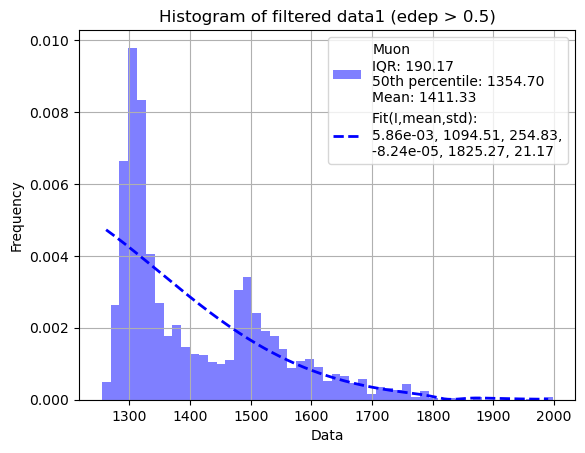

Error in <TFile::Init>: file ../TierIIData/2023_06/GC3_Muon/Rst_GC3_Muon_60_163576_0_0.root has an incorrect header length (242) or incorrect end of file length (224)
Error in <TFile::Init>: file ../TierIIData/2023_06/GC3_Muon/Rst_GC3_Muon_60_163576_0_0.root has an incorrect header length (242) or incorrect end of file length (224)


In [7]:
# Rest of the code...

# Create the figure and axes
fig, ax = plt.subplots()
ax.grid(True)  # Add a grid
ax.set_xlabel("Data")  # Set x-axis label
ax.set_ylabel("Frequency")  # Set y-axis label
ax.set_title("Histogram of filtered data1 (edep > 0.5)")  # Set the plot title

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here
#ax.set_xlim(1100, 1900)

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fLOapprox"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram
plot_histogram_from_folder_Landau("../TierIIData/2023_06/GC3_Muon", tree_name, branch_name, save_folder, fig, ax, "blue",'Muon',2000,0,1)
# Add the legend to the plot
ax.legend()
print(legend_labels)
# Save the histogram as a figure
plt.savefig("histogram_defGC3rnd.png")
# Show the plot
plt.show()

Reading X data
68
Fit Gauss
x2
fit_histogramG
[0.012994321820337832, 1397.4974178231146, 115.56700035812062, 0.0025988643640675667, 1538.7459738163732, 64.20388908784479]
Reading X data
26
Fit Gauss
x2
fit_histogramG
[0.00895267936860902, 1328.136760499774, 106.94528074665052, 0.001790535873721804, 1458.8476591901247, 59.41404485925029]
[]


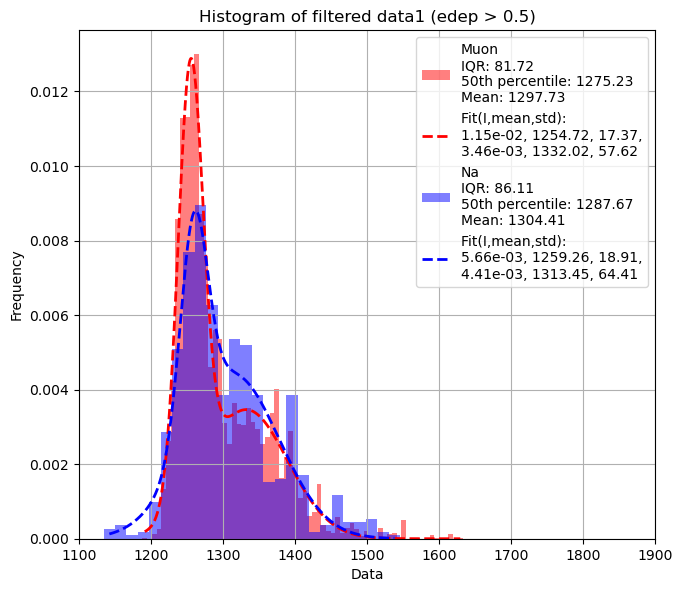

Error in <TFile::Init>: file ../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2/Rst_GC3_Muon_0_513_591_101293_591_0.root has an incorrect header length (260) or incorrect end of file length (242)
Error in <TFile::Init>: file ../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2/Rst_GC3_Muon_0_513_591_101293_591_0.root has an incorrect header length (260) or incorrect end of file length (242)


In [8]:
# Rest of the code...

# Create the figure and axes
fig, ax = plt.subplots(figsize=(textwidth * 0.45, textwidth * 0.4))
ax.grid(True)  # Add a grid
ax.set_xlabel("Data")  # Set x-axis label
ax.set_ylabel("Frequency")  # Set y-axis label
ax.set_title("Histogram of filtered data1 (edep > 0.5)")  # Set the plot title

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here
ax.set_xlim(1100, 1900)

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fLOapprox"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram

data=plot_histogram_from_folder_Landau("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "red",'Muon',1700)
plot_histogram_from_folder_Landau("../TierIIData/2023_02/Rst_GC3_Na_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",'Na')
# Add the legend to the plot
ax.legend()
print(legend_labels)
# Save the histogram as a figure
plt.savefig("histogram_defGC3.png")
# Show the plot
plt.show()

Reading X data
77
Fit Gauss
x2
fit_histogramG
[0.009987863235446093, 1264.2922933402292, 185.2572144870975, 0.0019975726470892186, 1490.7177777133484, 102.92067471505418]
Reading X data
31
Fit Gauss
x2
fit_histogramG
[0.008398870447210766, 1397.8601796363873, 91.46973356605422, 0.0016797740894421533, 1509.6565206615649, 50.8165186478079]
[]


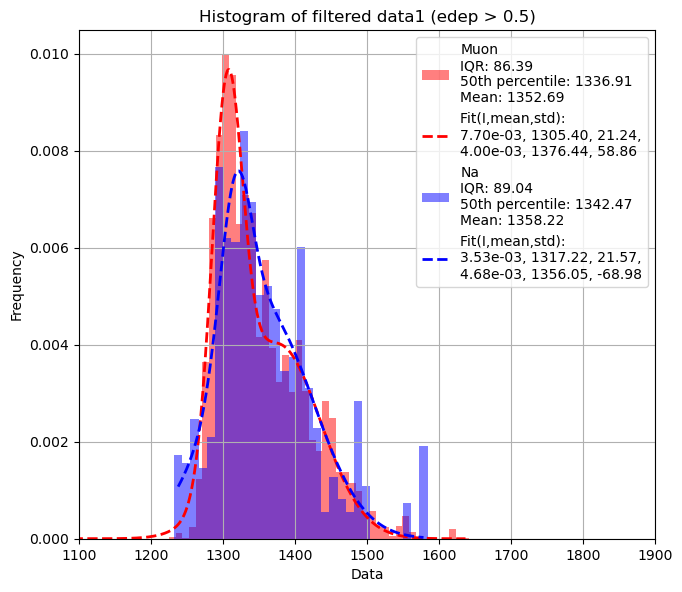

In [9]:
# Rest of the code...

# Create the figure and axes
fig, ax = plt.subplots(figsize=(textwidth * 0.45, textwidth * 0.4))
ax.grid(True)  # Add a grid
ax.set_xlabel("Data")  # Set x-axis label
ax.set_ylabel("Frequency")  # Set y-axis label
ax.set_title("Histogram of filtered data1 (edep > 0.5)")  # Set the plot title

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here
ax.set_xlim(1100, 1900)

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fLOapprox"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram

plot_histogram_from_folder_Landau("../TierIIData/2023_02/Rst_FL_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "red",'Muon')
plot_histogram_from_folder_Landau("../TierIIData/2023_02/Rst_FL_Na_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",'Na')

# Add the legend to the plot
ax.legend()
print(legend_labels)
# Save the histogram as a figure
plt.savefig("histogram_defFL.png")
# Show the plot
plt.show()

Reading X data
54
Fit Gauss
x2
fit_histogramG
[0.009723213755026893, 1548.2480745603082, 85.1164190849623, 0.0019446427510053787, 1652.2792534419289, 47.28689949164572]
Reading X data
29
Fit Gauss
x2
fit_histogramG
[0.010822910770691477, 1543.49346142916, 97.30640095360549, 0.0021645821541382954, 1662.4235070391223, 54.059111640891935]
[]


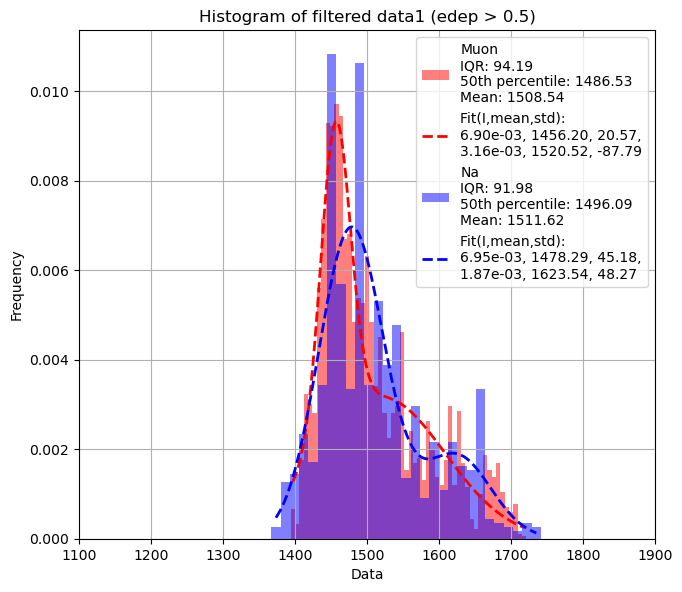

In [10]:

# Create the figure and axes
fig, ax = plt.subplots(figsize=(textwidth * 0.45, textwidth * 0.4))
ax.grid(True)  # Add a grid
ax.set_xlabel("Data")  # Set x-axis label
ax.set_ylabel("Frequency")  # Set y-axis label
ax.set_title("Histogram of filtered data1 (edep > 0.5)")  # Set the plot title

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here
ax.set_xlim(1100, 1900)

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fLOapprox"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram

plot_histogram_from_folder_Landau("../TierIIData/2023_02/Rst_SingleSiPM_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "red",'Muon')
plot_histogram_from_folder_Landau("../TierIIData/2023_02/Rst_SingleSiPM_Na_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",'Na')

# Add the legend to the plot
ax.legend()
print(legend_labels)
# Save the histogram as a figure
plt.savefig("histogram_defSingle.png")
# Show the plot
plt.show()

Reading X data
78
Fit Landau
[0.0073425531932796466, 1333.2000000000003, 884.4279186969335]
Reading X data
81
Fit Landau
[0.004819941246462366, 1910.15, 1397.6584769202368]
[]


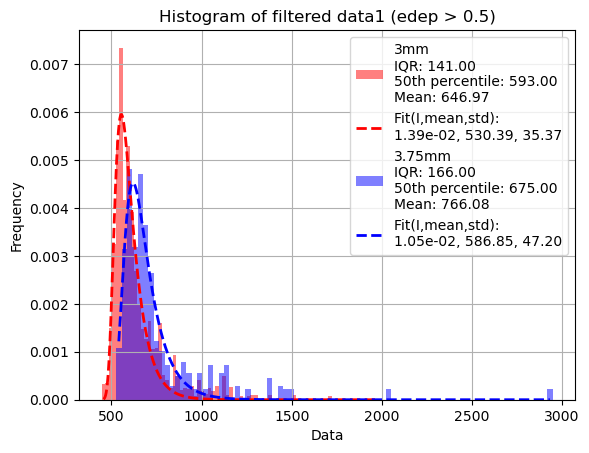

In [11]:
# Rest of the code...

# Create the figure and axes
fig, ax = plt.subplots()
ax.grid(True)  # Add a grid
ax.set_xlabel("Data")  # Set x-axis label
ax.set_ylabel("Frequency")  # Set y-axis label
ax.set_title("Histogram of filtered data1 (edep > 0.5)")  # Set the plot title

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here
#ax.set_xlim(1100, 1900)

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fHits"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram

plot_histogram_from_folder_Landau("../TierIIData/2023_06/BC408_FL_Char", tree_name, branch_name, save_folder, fig, ax, "red",'3mm',0,1,0)
plot_histogram_from_folder_Landau("../TierIIData/2023_06/BC408_FL_Char_SiPM125", tree_name, branch_name, save_folder, fig, ax, "blue",'3.75mm',0,1,0)
# Add the legend to the plot
ax.legend()
print(legend_labels)
# Save the histogram as a figure
plt.savefig("histogram_defGC3BC408.png")
# Show the plot
plt.show()

Reading X data
77
Fit Gauss
x2
fit_histogramG
[0.009987863235446093, 1264.2922933402292, 185.2572144870975, 0.0019975726470892186, 1490.7177777133484, 102.92067471505418]
Reading X data
27
Fit Gauss
x2
fit_histogramG
[0.011450277730229426, 1404.9816892236613, 96.54106024322085, 0.002290055546045885, 1522.9763184098201, 53.63392235734492]
[]


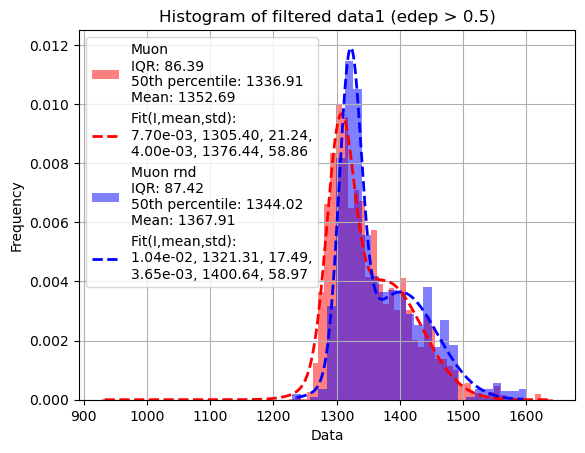

In [12]:
# Rest of the code...

# Create the figure and axes
fig, ax = plt.subplots()
ax.grid(True)  # Add a grid
ax.set_xlabel("Data")  # Set x-axis label
ax.set_ylabel("Frequency")  # Set y-axis label
ax.set_title("Histogram of filtered data1 (edep > 0.5)")  # Set the plot title

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here
#ax.set_xlim(1100, 1900)

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fLOapprox"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram
plot_histogram_from_folder_Landau("../TierIIData/2023_02/Rst_FL_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "red",'Muon',0,0,1)
#plot_histogram_from_folder("../TierIIData/2023_02/Rst_FL_Na_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",'Na')
#plot_histogram_from_folder_Landau("../TierIIData/2023_06/rnd_FL_Na", tree_name, branch_name, save_folder, fig, ax, "red",'Na',0,0,0)
plot_histogram_from_folder_Landau("../TierIIData/2023_06/rnd_FL_Muon", tree_name, branch_name, save_folder, fig, ax, "blue",'Muon rnd',0,0,1)
# Add the legend to the plot
ax.legend()
print(legend_labels)
# Save the histogram as a figure
plt.savefig("histogram_defGC3BC408.png")
# Show the plot
plt.show()

Reading X data
27
Fit Gauss
fit_histogramG1
[1, 964.7749510763208, 388.96419395436294]
Reading X data
27
Fit Gauss
x2
fit_histogramG
[0.011450277730229426, 1404.9816892236613, 96.54106024322085, 0.002290055546045885, 1522.9763184098201, 53.63392235734492]
[]


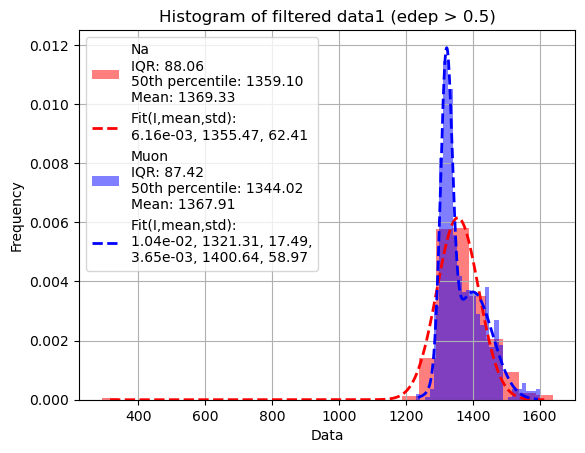

In [13]:
# Rest of the code...

# Create the figure and axes
fig, ax = plt.subplots()
ax.grid(True)  # Add a grid
ax.set_xlabel("Data")  # Set x-axis label
ax.set_ylabel("Frequency")  # Set y-axis label
ax.set_title("Histogram of filtered data1 (edep > 0.5)")  # Set the plot title

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here
#ax.set_xlim(1100, 1900)

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fLOapprox"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram

plot_histogram_from_folder_Landau("../TierIIData/2023_06/rnd_FL_Na", tree_name, branch_name, save_folder, fig, ax, "red",'Na',0,0,0)
plot_histogram_from_folder_Landau("../TierIIData/2023_06/rnd_FL_Muon", tree_name, branch_name, save_folder, fig, ax, "blue",'Muon',0,0,1)
# Add the legend to the plot
ax.legend()
print(legend_labels)
# Save the histogram as a figure
plt.savefig("histogram_defGC3BC408.png")
# Show the plot
plt.show()

In [31]:
# Rest of the code...

# Create the figure and axes
fig, ax = plt.subplots()
ax.grid(True)  # Add a grid
ax.set_xlabel("Data")  # Set x-axis label
ax.set_ylabel("Frequency")  # Set y-axis label
ax.set_title("Histogram of filtered data1 (edep > 0.5)")  # Set the plot title

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here
#ax.set_xlim(1100, 1900)

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fLOapprox"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram

plot_histogram_from_folder_Landau("../TierIIData/2023_06/rnd_FL_Muon", tree_name, branch_name, save_folder, fig, ax, "red",'Na',0,0,0)
plot_histogram_from_folder_Landau("../TierIIData/2023_06/FL_Muon", tree_name, branch_name, save_folder, fig, ax, "blue",'Muon',0,0,1)
# Add the legend to the plot
ax.legend()
print(legend_labels)
# Save the histogram as a figure
plt.savefig("histogram_defGC3BC408.png")
# Show the plot
plt.show()

Reading X data
27
Fit Gauss
fit_histogramG1
[1, 1415.7084736951304, 107.26784471468984]
Reading X data
42
Fit Gauss
x2
fit_histogramG
[0.01453823170929609, 1421.3025651631906, 92.12685059199589, 0.002907646341859218, 1533.9020492200746, 51.181583662219936]
[]


/tmp/ipykernel_54110/1940143422.py:33: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [30]:
# Rest of the code...

# Create the figure and axes
fig, ax = plt.subplots()
ax.grid(True)  # Add a grid
ax.set_xlabel("Data")  # Set x-axis label
ax.set_ylabel("Frequency")  # Set y-axis label
ax.set_title("Histogram of filtered data1 (edep > 0.5)")  # Set the plot title

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here
#ax.set_xlim(1100, 1900)

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fLOapprox"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram
plot_histogram_from_folder_Landau("../TierIIData/2023_06/GC3_Muon", tree_name, branch_name, save_folder, fig, ax, "blue",'Muon',0,0,1)
# Add the legend to the plot
ax.legend()
print(legend_labels)
# Save the histogram as a figure
plt.savefig("histogram_defGC3rnd.png")
# Show the plot
plt.show()

Reading X data
52
Fit Gauss
x2
fit_histogramG
[0.0037443332795904336, 5131.701666304236, 2137.847200416066, 0.0007488666559180867, 7744.626022368316, 1187.6928891200364]
[]


/tmp/ipykernel_54110/1527000209.py:31: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
Error in <TFile::Init>: file ../TierIIData/2023_06/GC3_Muon/Rst_GC3_Muon_60_163576_0_0.root has an incorrect header length (242) or incorrect end of file length (224)
Error in <TFile::Init>: file ../TierIIData/2023_06/GC3_Muon/Rst_GC3_Muon_60_163576_0_0.root has an incorrect header length (242) or incorrect end of file length (224)


Reading X data
54
Fit Landau
[0.0005285535639849942, 17907.45, 12463.43203543277]
Reading X data
54
Fit Landau
x2
[0.00023646380024122326, 12017.331491108074, 8854.168508891926, 0.00023646380024122326, 29725.668508891926, 8854.168508891926]


AttributeError: 'Line2D' object has no attribute 'set_fontsize'

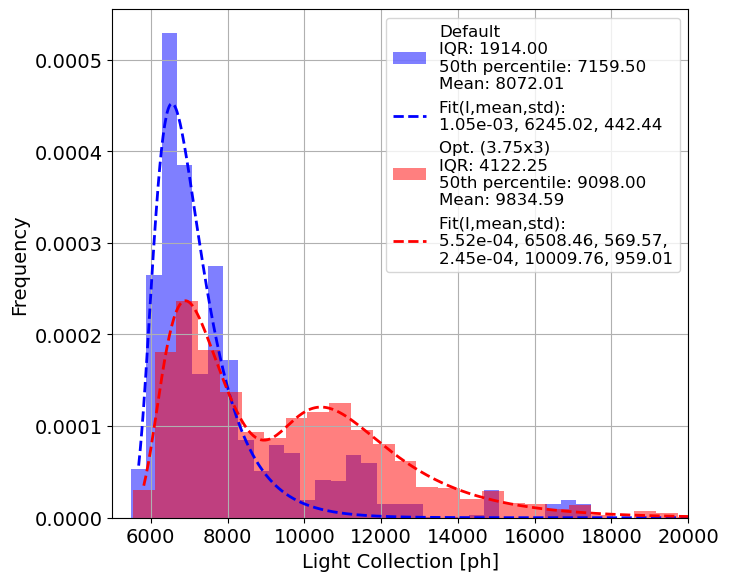

In [16]:
# Rest of the code...

# Create the figure and axes
fig, ax = plt.subplots(figsize=(textwidth * 0.45, textwidth * 0.4))
ax.grid(True)  # Add a grid
ax.set_xlabel("Data")  # Set x-axis label
ax.set_ylabel("Frequency")  # Set y-axis label

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here
ax.set_xlim(5000, 20000)

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fHits"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram
plot_histogram_from_folder_Landau("../TierIIData/2023_02/Rst_FL_Muon_23-02-10_SiPM375", tree_name, branch_name, save_folder, fig, ax, "blue",'Default',0,1,0)

plot_histogram_from_folder_Landau("../TierIIData/2023_02/Final_NSGAII_375x3", tree_name, branch_name, save_folder, fig, ax, "red",'Opt. (3.75x3)',0,1,1)

    # Increase the font size of the axis labels, tick numbers, and legend
ax.set_xlabel('Light Collection [ph]', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.tick_params(axis='both', labelsize=14)
    # Increase the font size of the line label
legend = ax.legend(fontsize=12)

    # Change the font size of the line label
for line in legend.get_lines():
        line.set_fontsize(12.5)
        
        
# Add the legend to the plot
ax.legend()
print(legend_labels)
# Save the histogram as a figure
plt.savefig("histogram_Opt_Def.png")
# Show the plot
plt.show()

Reading X data
68
[0.004867536652036233, 6324.7272627968005, 2832.392925831033, 0.0009735073304072466, 9786.540838812507, 1573.551625461685]


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.

Error in <TFile::Init>: file ../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2/Rst_GC3_Muon_0_513_591_101293_591_0.root has an incorrect header length (260) or incorrect end of file length (242)
Error in <TFile::Init>: file ../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2/Rst_GC3_Muon_0_513_591_101293_591_0.root has an incorrect header length (260) or incorrect end of file length (242)


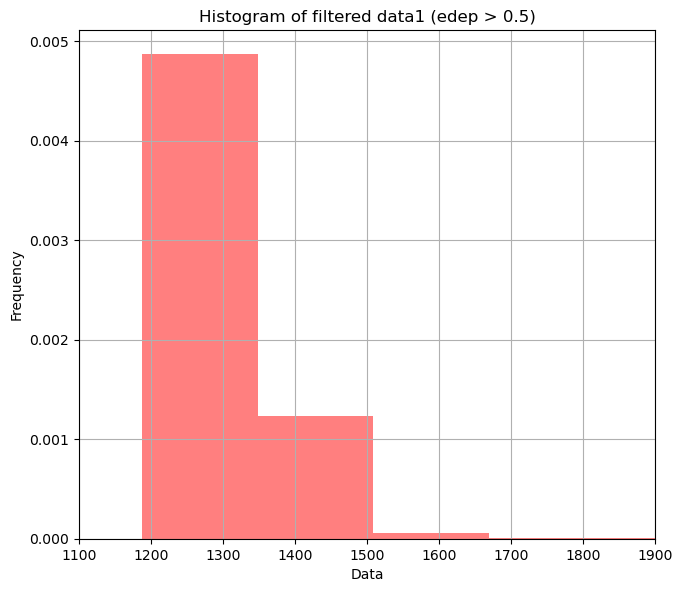

In [17]:
# Rest of the code...

# Create the figure and axes
fig, ax = plt.subplots(figsize=(textwidth * 0.45, textwidth * 0.4))
ax.grid(True)  # Add a grid
ax.set_xlabel("Data")  # Set x-axis label
ax.set_ylabel("Frequency")  # Set y-axis label
ax.set_title("Histogram of filtered data1 (edep > 0.5)")  # Set the plot title

# Set the maximum x-axis value
max_x_value = 2500  # Set your desired maximum value here
ax.set_xlim(1100, 1900)

# Usage example:
tree_name = "EndOfEvent"
branch_name = "fLOapprox"
save_folder = "CSV/"
legend_labels=[]
# Plot the first histogram
#legend_labels=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",legend_labels)
#plot_histogram_from_folder(folder, tree_name, branch_name, save_folder, fig, ax, "red")

# Plot the second histogram

data=plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "red",'Muon')
#plot_histogram_from_folder("../TierIIData/2023_02/Rst_GC3_Na_23-02-09v2", tree_name, branch_name, save_folder, fig, ax, "blue",'Na')
print(data)
# Add the legend to the plot
ax.legend()
print(legend_labels)
# Save the histogram as a figure
plt.savefig("histogram_filtered_data1.png")
# Show the plot
plt.show()

In [ ]:
import math
import numpy as np
from bokeh.plotting import figure, show, output_file
from bokeh.io import export_png

# Define the variables
treeName1 = "EndOfEvent"
branchName1 = "fLOapprox"

saveFolder = "CSV/"
treeName3 = "EndOfEvent"
branchName4 = "fDdep"
textwidth = 16.51

# Read data from root file
print("Reading X data")
with contextlib.redirect_stdout(io.StringIO()):
    data1 = readRootDataFromFolder(folder, treeName1, branchName1)
    edep = readRootDataFromFolder(folder, treeName1, "fEdep")

# Filter data based on edep values
filtered_data1 = [data1[i] for i in range(len(edep)) if edep[i] > 0.5]

# Calculate the number of bins using sqrt(n)
num_bins = int(math.sqrt(len(filtered_data1)))

# Create histogram data
hist, edges = np.histogram(filtered_data1, bins=num_bins)

# Create a Bokeh figure
p = figure(title="Histogram of filtered data1 (edep > 0.5)", x_axis_label="Data", y_axis_label="Frequency",
           plot_width=int(textwidth * 0.45 * 100), plot_height=int(textwidth * 0.4 * 100))

# Plot the histogram as a step line
p.step(edges.repeat(2)[1:-1], hist.repeat(2), line_color='blue', line_width=2)

# Save the histogram as an HTML file
output_file(saveFolder + "histogram_filtered_data1.html")

# Export the plot as a PNG image
export_png(p, filename=saveFolder + "histogram_filtered_data1.png")

# Display the plot
show(p)


In [ ]:

def Hist_plot_1xLO(folder: str, output_filename: str, npol: int):
    # Define the variables
    treeName1 = "EndOfEvent"
    branchName1 = "fLOapprox"

    xMin = -29
    xMax = 29
    yMin = 0
    yMax = 6000
    saveFolder = "CSV/"
    treeName3 = "EndOfEvent"
    branchName4 = "fDdep"
    textwidth = 16.51

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(textwidth * 0.45, textwidth * 0.4))

    # Read data from root file
    print("Reading X data")
    with contextlib.redirect_stdout(io.StringIO()):
        data1 = readRootDataFromFolder(folder, treeName1, branchName1)
        edep = readRootDataFromFolder(folder, treeName1, "fEdep")



    # Set the y-axis label
    ax.set_ylabel("Value")

    # Set the plot title
    ax.set_title("Box Plot of Data in Each Range")

    # Set the x-axis limits
    ax.set_xlim(-30, 30)

    # Round the x-axis tick labels to the first decimal place
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
        # Add a grid
    ax.grid(True, axis='y', linestyle='--', color='lightgray')
    # Add labels
    ax.set_xlabel(r'Length [mm]')
    ax.set_ylabel(r'Light Output [ph/MeV]')

    # Customize the color of all boxes
    for box in boxplot['boxes']:
        box.set_color('blue')

    # Set the number of divisions on the x-axis
    num_divisions = 10  # Choose the desired number of divisions
    ax.xaxis.set_major_locator(mticker.MaxNLocator(num_divisions))

    # Calculate the mean of each box
    box_means = [np.mean(data) for data in data_in_ranges]
    ax.plot(box_positions, box_means, 'ro', markersize=5)

    # Remove the title
    ax.set_title('')

    x=box_positions
    y=box_means
    x_filtered = [x_val for x_val, y_val in zip(x, y) if not math.isnan(y_val)]
    y_filtered = [y_val for y_val in y if not math.isnan(y_val)]

    # Add a parabolic fit to the mean values
    x_fit = np.linspace(min(x_filtered), max(x_filtered), 100)
    y_fit = np.polyval(np.polyfit(x_filtered, y_filtered, npol), x_fit)
    ax.plot(x_fit, y_fit, color='red', linestyle='--')

    # Increase the font size of the axes labels
    plt.xlabel('Length [mm]', fontsize=18)
    plt.ylabel('Light Output [ph/MeV]', fontsize=18)
    
        # Customize the legend
    legend_elements = [
    Line2D([0], [0], marker='o', color='black', markersize=5, label='Outliers', linestyle='None'),
    Line2D([0], [0], marker='o', color='red', markersize=5, label='Mean', linestyle='None')
    ]

    # Increase the font size of the tick labels
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    # Add the legend to the plot
    ax.legend(handles=legend_elements, loc='upper right',fontsize=18)

    # Save the figure as a PDF
    plt.savefig(output_filename, format='pdf')

    # Show the plot
    plt.show()
    return

Reading X data


/home/greales/miniconda3/envs/rootenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/greales/miniconda3/envs/rootenv/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[ -2.05369879 -13.03698833  -3.56450406  -2.08796368  19.23945478
  19.91663067  -2.4189877   -2.10853412   3.15748003  -9.13099896
 -10.43310772  -0.80078228  -2.25466507  -4.99103476  -1.80143573
  25.63309483  -2.05167349  -5.26068402   0.34700504   0.76893496
   0.57622011  -0.46720659   2.38061794  -2.18384798  -5.57945999
  -6.59952582 -14.39933838  -1.81354806   0.87602963  -5.65922828
  11.23219068  18.3669174   11.82689352   3.08974974 -10.30871368
  -7.58576612  -0.81952571]


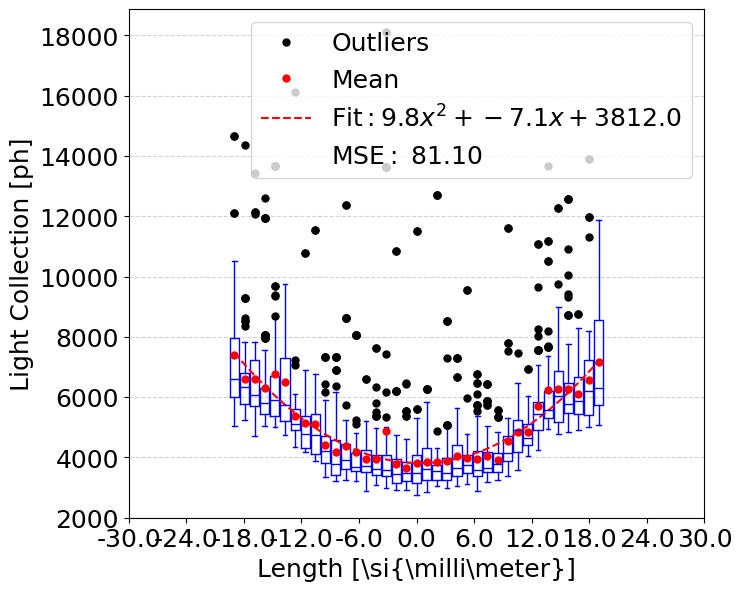

Reading X data
[-28.472727272727276, -27.41818181818182, -26.363636363636367, -25.30909090909091, -24.254545454545454, -23.200000000000003, -22.145454545454548, -21.090909090909093, -20.03636363636364, -18.981818181818188, -17.92727272727273, -16.872727272727275, -15.818181818181822, -14.763636363636367, -13.709090909090913, -12.654545454545456, -11.600000000000003, -10.545454545454549, -9.490909090909096, -8.436363636363637, -7.381818181818184, -6.32727272727273, -5.272727272727276, -4.218181818181822, -3.163636363636368, -2.1090909090909142, -1.0545454545454604, -6.613633252161577e-15, 1.054545454545451, 2.1090909090909045, 3.163636363636362, 4.218181818181815, 5.272727272727269, 6.327272727272723, 7.3818181818181765, 8.43636363636363, 9.490909090909085, 10.545454545454538, 11.6, 12.654545454545453, 13.709090909090907, 14.76363636363636, 15.818181818181815, 16.872727272727268, 17.927272727272722, 18.981818181818177, 20.03636363636363, 21.09090909090909, 22.145454545454538, 23.1999999

/home/greales/miniconda3/envs/rootenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/greales/miniconda3/envs/rootenv/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


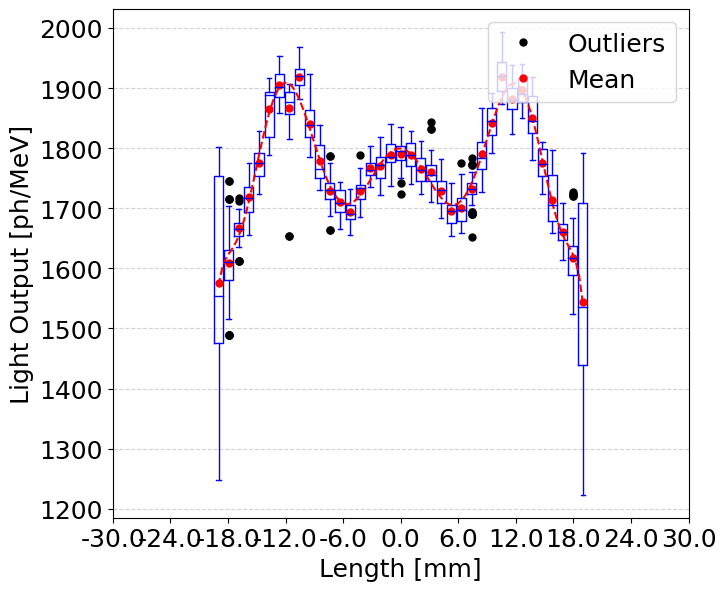

Reading X data


/home/greales/miniconda3/envs/rootenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/greales/miniconda3/envs/rootenv/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[ 2.22250358 -3.72251689 -0.04028797 -0.65149114 -1.31453395 -1.31594511
 -3.11043401 -0.63187041  2.36805742 -0.43144233  4.16127702  5.06699686
 -1.95819151  1.92772589  3.42141581  0.660672    0.21658554 -1.01216615
  0.93962387  3.32476122 -3.93827309  0.61651881 -1.982216    0.72611146
  0.1002925  -4.89938419  1.38178189 -0.19579366  1.83567332  0.16654288
 -2.16164658 -1.37566738  0.60024183 -2.86670406  0.35176118 -0.48204852
 -2.11636327  0.26012561  0.72980171 -2.74131329 -2.97542852  0.68619572
  3.0388407  -1.82997979  0.18865396 -2.57298487  2.79169092 -0.47926102
  6.69546404 -3.99220159  4.97051024 -2.99590859  0.17230609 -0.74334987
  6.24740277 -2.38462363 -0.18758245  4.52766861 -1.24976451  0.67272419
 -0.2664866   1.06845114  0.23540394  1.48629705  1.04427216 -0.2097126
 -1.1996056  -2.6766578  -2.95724633 -3.60963061 -1.44180237 -2.73998984
 -1.83625038  4.6991938   0.78560407  2.90760672]


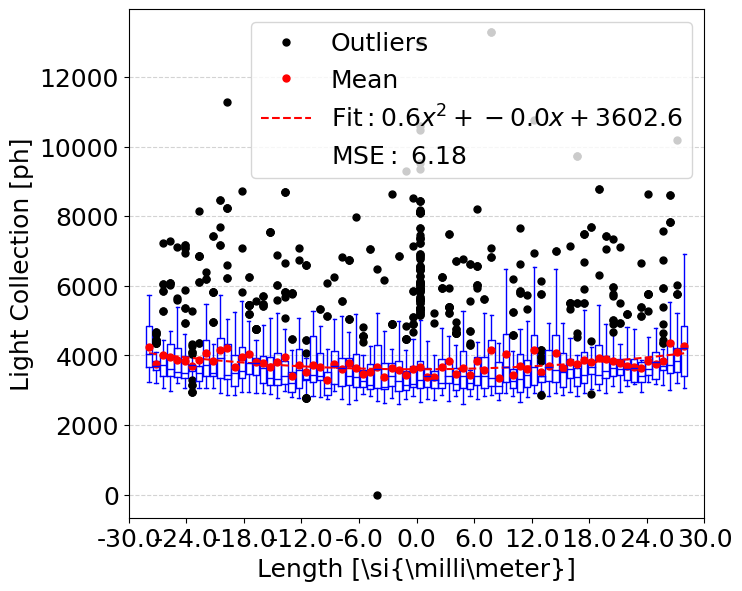

Reading X data
[-28.62820512820513, -27.884615384615383, -27.141025641025642, -26.3974358974359, -25.653846153846153, -24.910256410256412, -24.16666666666667, -23.42307692307692, -22.67948717948718, -21.935897435897438, -21.19230769230769, -20.44871794871795, -19.7051282051282, -18.96153846153846, -18.21794871794872, -17.474358974358978, -16.73076923076923, -15.987179487179489, -15.243589743589745, -14.500000000000002, -13.756410256410257, -13.012820512820513, -12.269230769230772, -11.525641025641027, -10.782051282051283, -10.038461538461542, -9.294871794871797, -8.551282051282055, -7.807692307692309, -7.064102564102564, -6.320512820512823, -5.576923076923078, -4.833333333333334, -4.0897435897435885, -3.3461538461538445, -2.6025641025641035, -1.8589743589743588, -1.115384615384614, -0.3717948717948729, 0.3717948717948718, 1.1153846153846165, 1.858974358974358, 2.6025641025641026, 3.346153846153847, 4.0897435897435885, 4.83333333333333, 5.576923076923078, 6.320512820512819, 7.0641025641

/home/greales/miniconda3/envs/rootenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/greales/miniconda3/envs/rootenv/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


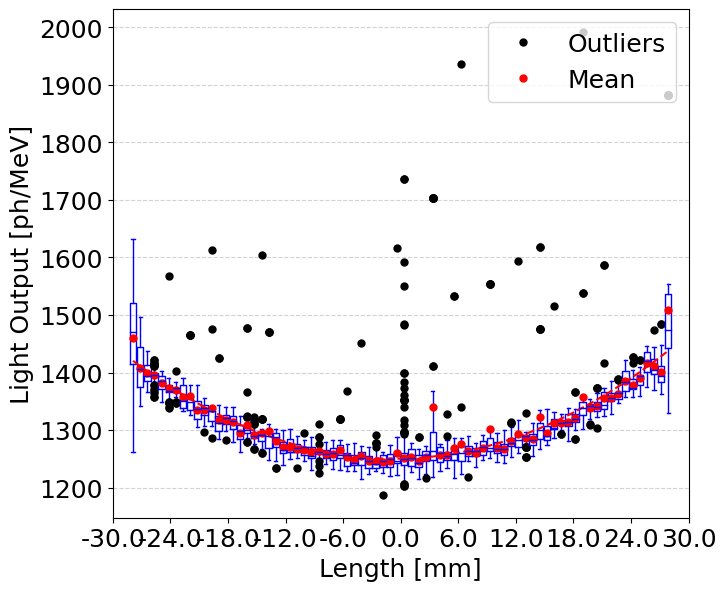

Reading X data
[ -8.40682205 -13.86759361 -17.57905468  15.29552151  -3.37027486
  12.71045012  30.83240129  -0.18927248   7.28355431  -9.22800619
  -6.36192673   2.6722831  -12.71040703   8.26938075  -0.26774692
  -2.67022612 -10.11899996  14.97432289  -7.2200528    7.78228053
   6.55136765  -5.79560135  11.54961784   6.15600466  -9.19589198
  -9.36789198   6.45190405  -4.16659136  -8.86469983   1.08697897
 -13.1379419    1.32795296   6.43082907  -3.3643244   -0.56720674
  -2.21351323   3.9526718   -1.35032583   8.69302232  -5.25092075
  -5.1933022   15.15825169  -2.67706115  -2.94488055  -6.25313936
  12.68642979  10.41150234  -9.08933605 -12.23668642  -5.59488947
   6.69507762  -5.04171597  -6.16626899  -8.94631675  22.43708441]


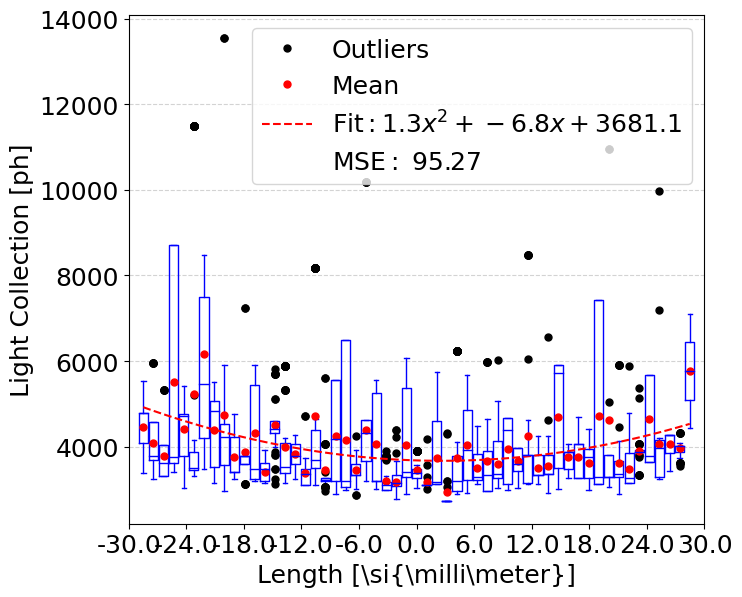

Reading X data
[-28.472727272727276, -27.41818181818182, -26.363636363636367, -25.30909090909091, -24.254545454545454, -23.200000000000003, -22.145454545454548, -21.090909090909093, -20.03636363636364, -18.981818181818188, -17.92727272727273, -16.872727272727275, -15.818181818181822, -14.763636363636367, -13.709090909090913, -12.654545454545456, -11.600000000000003, -10.545454545454549, -9.490909090909096, -8.436363636363637, -7.381818181818184, -6.32727272727273, -5.272727272727276, -4.218181818181822, -3.163636363636368, -2.1090909090909142, -1.0545454545454604, -6.613633252161577e-15, 1.054545454545451, 2.1090909090909045, 3.163636363636362, 4.218181818181815, 5.272727272727269, 6.327272727272723, 7.3818181818181765, 8.43636363636363, 9.490909090909085, 10.545454545454538, 11.6, 12.654545454545453, 13.709090909090907, 14.76363636363636, 15.818181818181815, 16.872727272727268, 17.927272727272722, 18.981818181818177, 20.03636363636363, 21.09090909090909, 22.145454545454538, 23.1999999

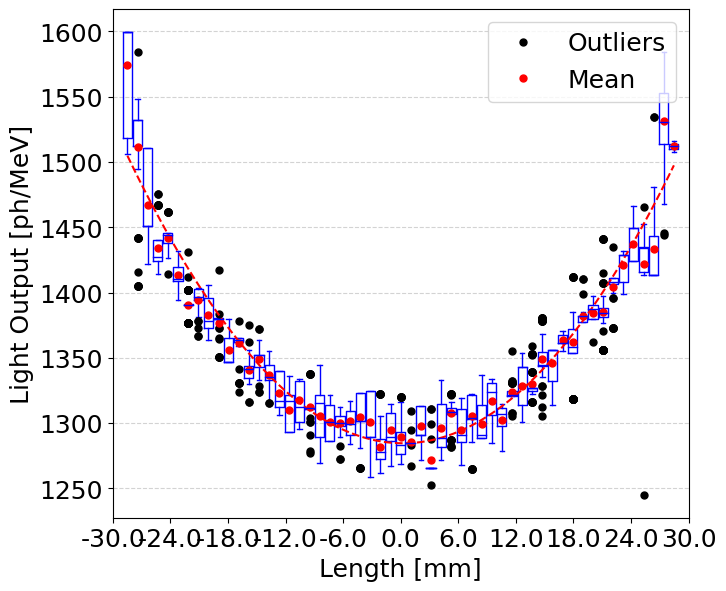

Reading X data


/home/greales/miniconda3/envs/rootenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/greales/miniconda3/envs/rootenv/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[-1.70072859e+00 -4.34936138e+00  1.82851773e+00 -3.54889238e+00
  3.53155087e+00 -5.10848872e+00  8.25671883e-01  8.74004811e+00
 -7.72927794e+00 -3.28083544e+00 -1.58648813e+00  1.36884437e+00
 -2.67298174e+00  1.00850164e+01 -9.19237530e-03 -2.01107040e+00
 -1.24863586e+00 -1.70645046e+00  2.31650717e+00  7.41468026e-03
  5.66893460e+00  6.98143439e+00  1.37605409e+00 -2.09542587e+00
 -1.02507594e+00  4.59189424e+00 -3.32978032e+00 -1.18316217e+00
 -1.62750436e-02  2.27965362e+00 -4.90858362e+00 -2.18543925e+00
 -3.41248295e+00  1.63204868e+00  1.13976285e+01  3.29649086e+00
  3.25433754e-01 -2.77462127e+00  5.10694680e+00 -6.23576794e-01
 -1.57040963e+00 -2.70113250e+00  4.02463891e-01 -2.61364837e+00
 -3.00148452e+00 -1.35122059e+00  1.04206422e+01  2.32170420e+00
 -9.39132021e-01 -8.93996748e-01 -8.87113159e-01 -4.12842572e+00
 -1.97483389e-01 -2.94584151e+00 -4.66954289e+00 -3.85370287e+00
  3.20218536e+00  1.90208169e+00  2.27837374e+00 -4.20645685e+00
 -2.75335567e+00 -4.05228

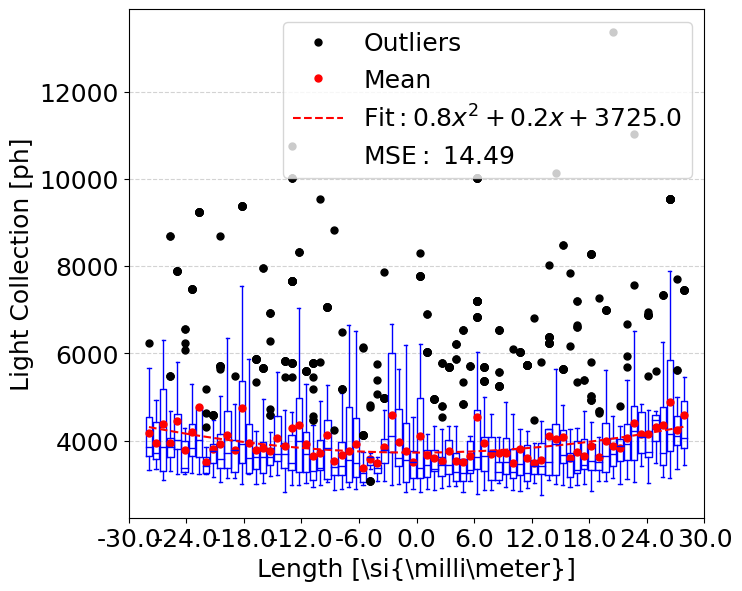

Reading X data
[-28.62820512820513, -27.884615384615383, -27.141025641025642, -26.3974358974359, -25.653846153846153, -24.910256410256412, -24.16666666666667, -23.42307692307692, -22.67948717948718, -21.935897435897438, -21.19230769230769, -20.44871794871795, -19.7051282051282, -18.96153846153846, -18.21794871794872, -17.474358974358978, -16.73076923076923, -15.987179487179489, -15.243589743589745, -14.500000000000002, -13.756410256410257, -13.012820512820513, -12.269230769230772, -11.525641025641027, -10.782051282051283, -10.038461538461542, -9.294871794871797, -8.551282051282055, -7.807692307692309, -7.064102564102564, -6.320512820512823, -5.576923076923078, -4.833333333333334, -4.0897435897435885, -3.3461538461538445, -2.6025641025641035, -1.8589743589743588, -1.115384615384614, -0.3717948717948729, 0.3717948717948718, 1.1153846153846165, 1.858974358974358, 2.6025641025641026, 3.346153846153847, 4.0897435897435885, 4.83333333333333, 5.576923076923078, 6.320512820512819, 7.0641025641

/home/greales/miniconda3/envs/rootenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/greales/miniconda3/envs/rootenv/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


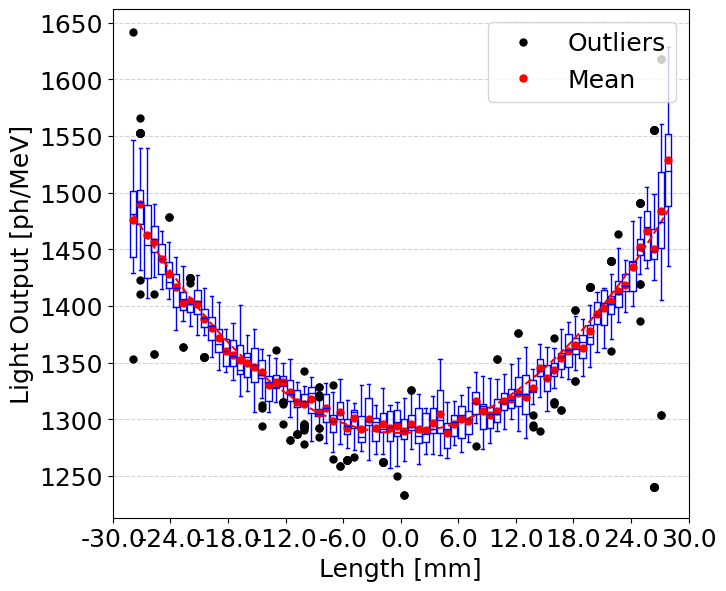

Error in <TFile::Init>: file ../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2/Rst_GC3_Muon_0_513_591_101293_591_0.root has an incorrect header length (260) or incorrect end of file length (242)
Error in <TFile::Init>: file ../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2/Rst_GC3_Muon_0_513_591_101293_591_0.root has an incorrect header length (260) or incorrect end of file length (242)
Error in <TFile::Init>: file ../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2/Rst_GC3_Muon_0_513_591_101293_591_0.root has an incorrect header length (260) or incorrect end of file length (242)
Error in <TFile::Init>: file ../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2/Rst_GC3_Muon_0_513_591_101293_591_0.root has an incorrect header length (260) or incorrect end of file length (242)
Error in <TFile::Init>: file ../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2/Rst_GC3_Muon_0_513_591_101293_591_0.root has an incorrect header length (260) or incorrect end of file length (242)
Error in <TFile::Init>: file ../TierIIData/20

In [18]:
%run BoxPlotFunctions.py
def run_box_plots(folders: List[str], output_filenames: List[str], polyns: List[int]):
    if len(folders) != len(output_filenames):
        print("Error: Number of folders and output filenames must be the same.")
        return

    for folder, output_filename, polyn in zip(folders, output_filenames, polyns):
        box_plot_1xLC(folder, output_filename+"LC.pdf")
        box_plot_1xLO(folder,output_filename+"LO.pdf",polyn)
        
folders=["../TierIIData/2023_02/Final_NSGAII_375x3",
         "../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2",
         "../TierIIData/2023_02/Rst_FL_Muon_23-02-10_SiPM375",
         "../TierIIData/2023_02/Rst_FL_Muon_23-02-09v2"]
fnames=[ "CSV/Figs/Final_NSGAII_375x3",
         "CSV/Figs/Rst_GC3_Muon_23-02-09v2",
         "CSV/Figs/Rst_FL_Muon_23-02-10_SiPM375",
         "CSV/Figs/Rst_FL_Muon_23-02-09v2"]
polyns=[10,
       2,
       2,
       2]
run_box_plots(folders,fnames,polyns)

#folder="../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2"
#folder="../TierIIData/2023_02/Rst_FL_Muon_23-02-10_SiPM375"
#folder="../TierIIData/2023_02/Rst_FL_Muon_23-02-09v2"

Reading X data
3000
3000
55
[-28.472727272727276, -27.41818181818182, -26.363636363636367, -25.30909090909091, -24.254545454545454, -23.200000000000003, -22.145454545454548, -21.090909090909093, -20.03636363636364, -18.981818181818188, -17.92727272727273, -16.872727272727275, -15.818181818181822, -14.763636363636367, -13.709090909090913, -12.654545454545456, -11.600000000000003, -10.545454545454549, -9.490909090909096, -8.436363636363637, -7.381818181818184, -6.32727272727273, -5.272727272727276, -4.218181818181822, -3.163636363636368, -2.1090909090909142, -1.0545454545454604, -6.613633252161577e-15, 1.054545454545451, 2.1090909090909045, 3.163636363636362, 4.218181818181815, 5.272727272727269, 6.327272727272723, 7.3818181818181765, 8.43636363636363, 9.490909090909085, 10.545454545454538, 11.6, 12.654545454545453, 13.709090909090907, 14.76363636363636, 15.818181818181815, 16.872727272727268, 17.927272727272722, 18.981818181818177, 20.03636363636363, 21.09090909090909, 22.14545454545453

/home/greales/miniconda3/envs/rootenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/greales/miniconda3/envs/rootenv/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


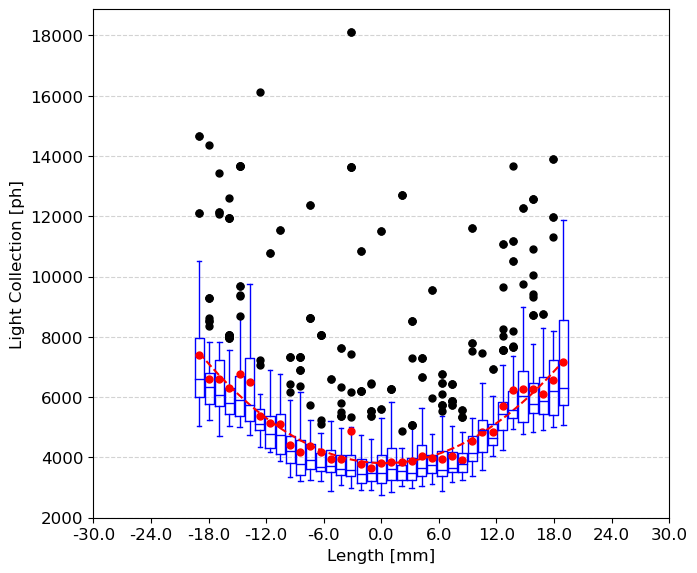

In [19]:
%run BoxPlotFunctions.py
import math
from typing import List
import contextlib
import io
import matplotlib.pyplot as plt


folder="../TierIIData/2023_02/Final_NSGAII_375x3"
#folder="../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2"
#folder="../TierIIData/2023_02/Rst_FL_Muon_23-02-10_SiPM375"
#folder="../TierIIData/2023_02/Rst_FL_Muon_23-02-09v2"

treeName1="EndOfEvent"
branchName1="fPrimaryZ"
treeName2="EndOfEvent"
branchName2="fphL"
treeName3="EndOfEvent"
branchName3="fphR"
plotName="EndOfEvent_fPrimaryZ_vs_fLC_box_NSGA_",
xMin=-29
xMax=29
yMin=0
yMax=6000
saveFolder="CSV/"
treeName3="EndOfEvent"
branchName4="fDdep",
# Create a figure and axes
textwidth=  16.51
#fig, ax = plt.subplots(figsize=(textwidth*0.3,textwidth*0.45))
fig, ax = plt.subplots(figsize=(textwidth*0.45,textwidth*0.4))

#ax.set_ylim(2000, 12000)

# Read data from root file

print("Reading X data")
with contextlib.redirect_stdout(io.StringIO()):
    data1 = readRootDataFromFolder(folder, treeName1, branchName1)
    data2 = readRootDataFromFolder(folder, treeName2, branchName2)
    data3 = readRootDataFromFolder(folder, treeName3, branchName3)
    #edep = readRootDataFromFolder(folder, treeName1, "fEdep")

print(len (data1))
print(len(data2))

n = int(np.ceil(np.sqrt(len(data1))))  # Number of ranges
print(n)
range_size = xMax * 2 / n
import matplotlib.pyplot as plt

# Create a list to store the data within each range
data_in_ranges = []
box_positions = []
box_widths = []
# Iterate over each range and extract the data within it
for i in range(n):
    range_min = xMin / 1000 + i * range_size / 1000
    range_max = range_min + range_size / 1000
    values_in_range = []
    for j in range(len(data1)):
        if range_min <= data1[j] < range_max:
            if data2[j] > 0 and data3[j] > 0:
                #if edep[j]>0.1:
                    values_in_range.append((data3[j] + data2[j]) / 2 )
    data_in_ranges.append(values_in_range)
    # Calculate the box position and width
    box_position = (range_min + range_max) / 2*1000
    box_width = 0.9 * (range_max - range_min)*1000
    box_positions.append(box_position)
    box_widths.append(box_width)


# Set the y-axis limits
print(box_positions)

# Plot the box plot for each range
boxplot=ax.boxplot(data_in_ranges, positions=box_positions, widths=box_widths, showfliers=True,
          patch_artist=False,  # Set patch_artist to False
                     whiskerprops=dict(color='blue'), capprops=dict(color='blue'),
                     medianprops=dict(color='blue'), flierprops=dict(marker='o', markersize=5,
                                                                     markerfacecolor='black'), whis=1.5)



# Set the y-axis label
ax.set_ylabel("Value")

# Set the plot title
ax.set_title("Box Plot of Data in Each Range")
# Set the x-axis limits
ax.set_xlim(-30, 30)

# Round the x-axis tick labels to the first decimal place
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
    # Add a grid
ax.grid(True, axis='y', linestyle='--', color='lightgray')
# Add labels
ax.set_xlabel('Length [mm]')
ax.set_ylabel('Light Collection [ph]')

# Customize the color of all boxes
for box in boxplot['boxes']:
    box.set_color('blue')

import matplotlib.ticker as mticker

# Set the number of divisions on the x-axis
num_divisions = 10  # Choose the desired number of divisions
ax.xaxis.set_major_locator(mticker.MaxNLocator(num_divisions))

# Calculate the mean of each box
box_means = [np.mean(data) for data in data_in_ranges]
ax.plot(box_positions, box_means, 'ro', markersize=5)

# Remove the title
ax.set_title('')

x=box_positions
y=box_means
x_filtered = [x_val for x_val, y_val in zip(x, y) if not math.isnan(y_val)]
y_filtered = [y_val for y_val in y if not math.isnan(y_val)]

#print(x)
#print(y)
#print(x_filtered)
#print(y_filtered)

# Add a parabolic fit to the mean values
x_fit = np.linspace(min(x_filtered), max(x_filtered), 100)
y_fit = np.polyval(np.polyfit(x_filtered, y_filtered, 2), x_fit)
ax.plot(x_fit, y_fit, color='red', linestyle='--')
#print(x_fit)
#print(y_fit)

# Increase the font size of the axes labels
plt.xlabel('Length [mm]', fontsize=12)
plt.ylabel('Light Collection [ph]', fontsize=12)

# Increase the font size of the tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save the figure as a PDF
output_filename = 'CSV/GC3_ROOT_6200.pdf'
plt.savefig(output_filename, format='pdf')

# Show the plot
plt.show()


In [20]:
import matplotlib as mpl
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots 
    "font.sans-serif": [],              # to inherit fonts from the document
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts 
    "xtick.labelsize": 8,               # a little smaller
    "ytick.labelsize": 8,
    #"figure.figsize": figsize(0.9),     # default fig size of 0.9 textwidth
    "pgf.preamble": "\n".join([ # plots will use this preamble
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[T1]{fontenc}",
        r"\usepackage[detect-all,locale=DE]{siunitx}",
        ])
    }
mpl.use("pgf")
mpl.rcParams.update(pgf_with_latex)


In [21]:
output_filename = 'CSV/GC3_ROOT_6200.pdf'
plt.savefig(output_filename, format='pdf')

In [22]:
import math
from typing import List
import contextlib
import io
import matplotlib.pyplot as plt


folder="../TierIIData/2023_02/Final_NSGAII_375x3"
folder="../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2"
#folder="../TierIIData/2023_02/Rst_FL_Muon_23-02-10_SiPM375"
folder="../TierIIData/2023_02/Rst_FL_Muon_23-02-09v2"

treeName1="EndOfEvent"
branchName1="fPrimaryZ"
treeName2="EndOfEvent"
branchName2="fphL"
treeName3="EndOfEvent"
branchName3="fphR"
plotName="EndOfEvent_fPrimaryZ_vs_fLC_box_NSGA_",
xMin=-29
xMax=29
yMin=0
yMax=6000
saveFolder="CSV/"
treeName3="EndOfEvent"
branchName4="fDdep",
# Create a figure and axes
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_ylim(1000, 2000)

# Read data from root file

print("Reading X data")
with contextlib.redirect_stdout(io.StringIO()):
    data1 = readRootDataFromFolder(folder, treeName1, branchName1)
    data2 = readRootDataFromFolder(folder, treeName2, branchName2)
    data3 = readRootDataFromFolder(folder, treeName3, branchName3)
    edep = readRootDataFromFolder(folder, treeName1, "fEdep")

print(len (data1))
print(len(data2))
print(len(edep))

n = 40  # Number of ranges
range_size = xMax * 2 / n
import matplotlib.pyplot as plt

# Create a list to store the data within each range
data_in_ranges = []
box_positions = []
box_widths = []
# Iterate over each range and extract the data within it
for i in range(n):
    range_min = xMin / 1000 + i * range_size / 1000
    range_max = range_min + range_size / 1000
    values_in_range = []
    for j in range(len(data1)):
        if range_min <= data1[j] < range_max:
            if data2[j] > 0 and data3[j] > 0:
                if edep[j]>0:
                    values_in_range.append((data3[j] + data2[j]) / 2 / edep[j])
    data_in_ranges.append(values_in_range)
    # Calculate the box position and width
    box_position = (range_min + range_max) / 2*1000
    box_width = 0.9 * (range_max - range_min)*1000
    box_positions.append(box_position)
    box_widths.append(box_width)


# Set the y-axis limits
print(box_positions)

# Plot the box plot for each range
boxplot=ax.boxplot(data_in_ranges, positions=box_positions, widths=box_widths, showfliers=True,
          patch_artist=False,  # Set patch_artist to False
                     whiskerprops=dict(color='blue'), capprops=dict(color='blue'),
                     medianprops=dict(color='blue'), flierprops=dict(marker='o', markersize=5,
                                                                     markerfacecolor='black'), whis=1.5)



# Set the y-axis label
ax.set_ylabel("Value")

# Set the plot title
ax.set_title("Box Plot of Data in Each Range")
# Set the x-axis limits
ax.set_xlim(-30, 30)

# Round the x-axis tick labels to the first decimal place
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
    # Add a grid
ax.grid(True, axis='y', linestyle='--', color='lightgray')
# Add labels
ax.set_xlabel('Length [mm]')
ax.set_ylabel('Light Collection [ph]')

# Customize the color of all boxes
for box in boxplot['boxes']:
    box.set_color('blue')

import matplotlib.ticker as mticker

# Set the number of divisions on the x-axis
num_divisions = 10  # Choose the desired number of divisions
ax.xaxis.set_major_locator(mticker.MaxNLocator(num_divisions))

# Calculate the mean of each box
box_means = [np.mean(data) for data in data_in_ranges]
ax.plot(box_positions, box_means, 'ro', markersize=5)

# Remove the title
ax.set_title('')

x=box_positions
y=box_means
x_filtered = [x_val for x_val, y_val in zip(x, y) if not math.isnan(y_val)]
y_filtered = [y_val for y_val in y if not math.isnan(y_val)]

print(x)
print(y)
print(x_filtered)
print(y_filtered)

# Add a parabolic fit to the mean values
x_fit = np.linspace(min(x_filtered), max(x_filtered), 100)
y_fit = np.polyval(np.polyfit(x_filtered, y_filtered, 2), x_fit)
ax.plot(x_fit, y_fit, color='red', linestyle='--')
print(x_fit)
print(y_fit)

# Save the figure as a PDF
output_filename = 'CSV/LC375_ROOT_LO.pdf'
plt.savefig(output_filename, format='pdf')
# Show the plot
plt.show()
print(box_means)
print(y_fit)

Reading X data
6000
6000
6000
[-28.275000000000002, -26.825000000000003, -25.375, -23.925, -22.475, -21.025000000000002, -19.575000000000003, -18.125, -16.675, -15.225000000000003, -13.775, -12.325000000000003, -10.875000000000004, -9.425000000000002, -7.975, -6.525000000000003, -5.075000000000003, -3.625000000000003, -2.1750000000000034, -0.725, 0.725, 2.1749999999999963, 3.6249999999999964, 5.075000000000003, 6.524999999999996, 7.974999999999996, 9.424999999999995, 10.874999999999996, 12.325000000000003, 13.774999999999995, 15.224999999999996, 16.674999999999997, 18.124999999999996, 19.575000000000003, 21.024999999999995, 22.475, 23.924999999999994, 25.374999999999996, 26.825000000000003, 28.274999999999995]
[-28.275000000000002, -26.825000000000003, -25.375, -23.925, -22.475, -21.025000000000002, -19.575000000000003, -18.125, -16.675, -15.225000000000003, -13.775, -12.325000000000003, -10.875000000000004, -9.425000000000002, -7.975, -6.525000000000003, -5.075000000000003, -3.6250000

/tmp/ipykernel_54110/360716558.py:136: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [23]:
x = [1, 2, 3, 4, 5, 6]
y = [1.0, 2.0, float('nan'), 4.0, float('nan'), 6.0]

x=box_positions
y=box_means
x_filtered = [x_val for x_val, y_val in zip(x, y) if not math.isnan(y_val)]
y_filtered = [y_val for y_val in y if not math.isnan(y_val)]

print(x_filtered)
print(y_filtered)

# Add a parabolic fit to the mean values
x_fit = np.linspace(min(x_filtered), max(x_filtered), 100)
y_fit = np.polyval(np.polyfit(y_filtered, x_filtered, 2), x_fit)
ax.plot(x_fit, y_fit, color='red', linestyle='--')
print(x_fit)
print(y_fit)

[-28.275000000000002, -26.825000000000003, -25.375, -23.925, -22.475, -21.025000000000002, -19.575000000000003, -18.125, -16.675, -15.225000000000003, -13.775, -12.325000000000003, -10.875000000000004, -9.425000000000002, -7.975, -6.525000000000003, -5.075000000000003, -3.625000000000003, -2.1750000000000034, -0.725, 0.725, 2.1749999999999963, 3.6249999999999964, 5.075000000000003, 6.524999999999996, 7.974999999999996, 9.424999999999995, 10.874999999999996, 12.325000000000003, 13.774999999999995, 15.224999999999996, 16.674999999999997, 18.124999999999996, 19.575000000000003, 21.024999999999995, 22.475, 23.924999999999994, 25.374999999999996, 26.825000000000003, 28.274999999999995]
[1476.4927044349038, 1477.4607798311192, 1451.5101886902924, 1420.107746360475, 1405.9306849412271, 1397.8741893036317, 1377.529565535813, 1361.693642303318, 1351.4919526197405, 1345.8609431686077, 1334.925723966615, 1329.9137241297392, 1319.314080350188, 1314.458219401147, 1308.247881110248, 1302.04954457787

In [24]:
import csv

# Calculate the statistics for each range
box_data = []
for values_in_range in data_in_ranges:
    if len(values_in_range) > 0:
        q1 = np.percentile(values_in_range, 25)
        q2 = np.percentile(values_in_range, 50)
        q3 = np.percentile(values_in_range, 75)
        minimum = min(values_in_range)
        maximum = max(values_in_range)
        mean = np.mean(values_in_range)
    else:
        q1 = q2 = q3 = minimum = maximum = mean = None
    box_data.append((minimum, q1, q2, q3, maximum, mean))

# Write the data to a CSV file
csv_filename = 'CSV/box_plot_data.csv'
with open(csv_filename, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['Minimum', 'Q1', 'Q2 (Median)', 'Q3', 'Maximum', 'Mean'])
    writer.writerows(box_data)
    
print(f"Box plot data saved to {csv_filename}")

Box plot data saved to CSV/box_plot_data.csv


In [25]:
import math
from typing import List
import contextlib
import io

folder1="../TierIIData/2023_02/Final_NSGAII_375x3"
folder="../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2"
#folder1="../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2"

#folder="../TierIIData/2023_02/Rst_FL_Muon_23-02-10_SiPM375"

treeName1="EndOfEvent"
branchName1="fPrimaryZ"
treeName2="EndOfEvent"
branchName2="fphL"
treeName3="EndOfEvent"
branchName3="fphR"
plotName="EndOfEvent_fPrimaryZ_vs_fLC_box_NSGA_",
xMin=-29
xMax=29
yMin=0
yMax=6000
saveFolder="CSV/"

# Read data from root file
print("Reading X data")
with contextlib.redirect_stdout(io.StringIO()):
    data1 = readRootDataFromFolder(folder, treeName1, branchName1)
    data2 = readRootDataFromFolder(folder, treeName2, branchName2)
    data3 = readRootDataFromFolder(folder, treeName3, branchName3)
    
with contextlib.redirect_stdout(io.StringIO()):
    data11 = readRootDataFromFolder(folder1, treeName1, branchName1)
    data21 = readRootDataFromFolder(folder1, treeName2, branchName2)
    data31 = readRootDataFromFolder(folder1, treeName3, branchName3)
    
n = 20  # Number of ranges
range_size = xMax * 2 / n
import matplotlib.pyplot as plt

# Create a list to store the data within each range
data_in_ranges = []
box_positions = []
box_widths = []
# Iterate over each range and extract the data within it
for i in range(n):
    range_min = xMin / 1000 + i * range_size / 1000
    range_max = range_min + range_size / 1000
    values_in_range = []
    for j in range(len(data1)):
        if range_min <= data1[j] < range_max:
            if data2[j] > 0 and data3[j] > 0:
                values_in_range.append((data3[j] + data2[j]) / 2)
    data_in_ranges.append(values_in_range)
    # Calculate the box position and width
    box_position = (range_min + range_max) / 2*1000
    box_width = 0.9 * (range_max - range_min)*1000
    box_positions.append(box_position)
    box_widths.append(box_width)

# Create a list to store the data within each range
data_in_ranges1 = []
box_positions1 = []
box_widths1 = []
range_size1 = 20 * 2 / n
# Iterate over each range and extract the data within it
for i in range(n):
    range_min1 = -20 / 1000 + i * range_size1 / 1000
    range_max1 = range_min1 + range_size1 / 1000
    values_in_range1 = []
    for j in range(len(data11)):
        if range_min1 <= data11[j] < range_max1:
            if data21[j] > 0 and data31[j] > 0:
                values_in_range1.append((data31[j] + data21[j]) / 2)
    data_in_ranges1.append(values_in_range1)
    # Calculate the box position and width
    box_position1 = (range_min1 + range_max1) / 2*1000
    box_width1 = 0.9 * (range_max1 - range_min1)*1000
    box_positions1.append(box_position1)
    box_widths1.append(box_width1)
# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))
# Set the y-axis limits
ax.set_ylim(2000, 10000)
print(box_positions)
print(box_positions1)

# Plot the box plot for each range
boxplot=ax.boxplot(data_in_ranges, positions=box_positions, widths=box_widths, showfliers=False,
          patch_artist=False,  # Set patch_artist to False
                     whiskerprops=dict(color='blue'), capprops=dict(color='blue'),
                     medianprops=dict(color='blue'), flierprops=dict(marker='o', markersize=5,
                                                                     markerfacecolor='black'))
# Plot the box plot for each range
boxplot1=ax.boxplot(data_in_ranges1, positions=box_positions1, widths=box_widths1, showfliers=False,
          patch_artist=False,  # Set patch_artist to False
                     whiskerprops=dict(color='red'), capprops=dict(color='red'),
                     medianprops=dict(color='red'), flierprops=dict(marker='o', markersize=5,
                                                                     markerfacecolor='black'))


# Set the y-axis label
ax.set_ylabel("Value")

# Set the plot title
ax.set_title("Box Plot of Data in Each Range")
# Set the x-axis limits
ax.set_xlim(-30, 30)

# Round the x-axis tick labels to the first decimal place
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
    # Add a grid
ax.grid(True, axis='y', linestyle='--', color='lightgray')
# Add labels
ax.set_xlabel('Length [mm]')
ax.set_ylabel('Light Collection [ph]')

# Customize the color of all boxes
for box in boxplot['boxes']:
    box.set_color('blue')
# Customize the color of all boxes
for box in boxplot1['boxes']:
    box.set_color('red')
import matplotlib.ticker as mticker

# Set the number of divisions on the x-axis
num_divisions = 10  # Choose the desired number of divisions
ax.xaxis.set_major_locator(mticker.MaxNLocator(num_divisions))

# Calculate the mean of each box
box_means = [np.mean(data) for data in data_in_ranges]
ax.plot(box_positions, box_means, 'bo', markersize=5)

# Calculate the mean of each box
box_means1 = [np.mean(data) for data in data_in_ranges1]
ax.plot(box_positions1, box_means1, 'ro', markersize=5)
# Remove the title
ax.set_title('')

# Save the figure as a PDF
output_filename = 'CSV/BOTH_ROOT.pdf'
plt.savefig(output_filename, format='pdf')

# Show the plot
plt.show()



Reading X data
[-27.55, -24.650000000000002, -21.750000000000004, -18.85, -15.950000000000003, -13.05, -10.150000000000002, -7.249999999999999, -4.350000000000003, -1.4500000000000033, 1.45, 4.349999999999996, 7.2499999999999964, 10.149999999999995, 13.050000000000002, 15.949999999999996, 18.849999999999994, 21.749999999999996, 24.649999999999995, 27.55]
[-19.000000000000004, -17.0, -15.0, -13.000000000000002, -11.0, -9.000000000000002, -7.0, -5.0, -3.0, -1.0000000000000018, 1.0, 2.9999999999999982, 5.0, 6.999999999999998, 9.000000000000002, 11.0, 13.000000000000002, 15.000000000000002, 16.999999999999993, 18.999999999999996]


/tmp/ipykernel_54110/3814837276.py:145: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
Error in <TFile::Init>: file ../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2/Rst_GC3_Muon_0_513_591_101293_591_0.root has an incorrect header length (260) or incorrect end of file length (242)
Error in <TFile::Init>: file ../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2/Rst_GC3_Muon_0_513_591_101293_591_0.root has an incorrect header length (260) or incorrect end of file length (242)
Error in <TFile::Init>: file ../TierIIData/2023_02/Rst_GC3_Muon_23-02-09v2/Rst_GC3_Muon_0_513_591_101293_591_0.root has an incorrect header length (260) or incorrect end of file length (242)


In [26]:
values_in_range1[0]

5677.0

In [27]:
n = 20  # Number of ranges
range_size = xMax * 2 / n

In [28]:
import matplotlib.pyplot as plt

# Create a list to store the data within each range
data_in_ranges = []

# Create a list to store the box positions
box_positions = []

# Create a list to store the box widths
box_widths = []

# Iterate over each range and extract the data within it
for i in range(n):
    range_min = xMin / 1000 + i * range_size / 1000
    range_max = range_min + range_size / 1000

    values_in_range = []

    for j in range(len(data1)):
        if range_min <= data1[j] < range_max:
            if data2[j] > 0 and data3[j] > 0:
                values_in_range.append((data3[j] + data2[j]) / 2)

    data_in_ranges.append(values_in_range)
    
    # Calculate the box position and width
    box_position = (range_min + range_max) / 2*1000
    box_width = 0.9 * (range_max - range_min)*1000
    
    box_positions.append(box_position)
    box_widths.append(box_width)

print(box_positions)
# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))
# Set the y-axis limits
ax.set_ylim(2000, 10000)

# Plot the box plot for each range
boxplot=ax.boxplot(data_in_ranges, positions=box_positions, widths=box_widths, showfliers=False,
          patch_artist=False,  # Set patch_artist to False
                     whiskerprops=dict(color='blue'), capprops=dict(color='blue'),
                     medianprops=dict(color='blue'), flierprops=dict(marker='o', markersize=5,
                                                                     markerfacecolor='black'))

# Set the x-axis labels
xticklabels = [f"Range {i+1}" for i in range(n)]
ax.set_xticklabels(xticklabels)

# Set the y-axis label
ax.set_ylabel("Value")

# Set the plot title
ax.set_title("Box Plot of Data in Each Range")
# Set the x-axis limits
ax.set_xlim(-30, 30)

# Round the x-axis tick labels to the first decimal place
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
    # Add a grid
ax.grid(True, axis='y', linestyle='--', color='lightgray')
# Add labels
ax.set_xlabel('Length [mm]')
ax.set_ylabel('Light Collection [ph]')

# Customize the color of all boxes
for box in boxplot['boxes']:
    box.set_color('blue')
    
import matplotlib.ticker as mticker

# Set the number of divisions on the x-axis
num_divisions = 10  # Choose the desired number of divisions
ax.xaxis.set_major_locator(mticker.MaxNLocator(num_divisions))

# Calculate the mean of each box
box_means = [np.mean(data) for data in data_in_ranges]
# Plot the box means with markers
ax.plot(box_positions, box_means, 'bo', markersize=5)
# Remove the title
ax.set_title('')

# Show the plot
plt.show()


[-27.55, -24.650000000000002, -21.750000000000004, -18.85, -15.950000000000003, -13.05, -10.150000000000002, -7.249999999999999, -4.350000000000003, -1.4500000000000033, 1.45, 4.349999999999996, 7.2499999999999964, 10.149999999999995, 13.050000000000002, 15.949999999999996, 18.849999999999994, 21.749999999999996, 24.649999999999995, 27.55]


/tmp/ipykernel_54110/3066786405.py:84: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [198]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a DataFrame
fnameGC3 = 'EndOfEvent_fPrimaryZ_vs_fLC_box_GC3__quartile_data'
fnameNSGA='EndOfEvent_fPrimaryZ_vs_fLC_box_NSGA_375x3_quartile_data'
fnameFLNSGA='EndOfEvent_fPrimaryZ_vs_fLC_box_NSGA_375x3_quartile_data'

folder='CSV/'
data = pd.read_csv(folder+fnameGC3+'.csv')
data

,Range Min,Range Max,Lower Quartile,Median,Upper Quartile,Mean,Std,Min,Max
0,-0.0290,-2.610000e-02,3614.0,3740.0,4114.0,3962.92,645.680,3051.5,6041.0
1,-0.0261,-2.320000e-02,3371.5,3604.0,4035.5,3879.38,875.729,2981.0,7287.5
2,-0.0232,-2.030000e-02,3388.0,3566.0,4000.0,3942.01,1010.750,2957.5,8462.5
3,-0.0203,-1.740000e-02,3339.5,3543.5,4317.5,3976.15,1128.560,2858.0,11280.0
4,-0.0174,-1.450000e-02,3219.5,3693.5,3968.5,3771.32,778.182,2884.5,7540.5
5,-0.0145,-1.160000e-02,3060.0,3358.5,3841.0,3652.24,962.722,2774.5,8707.0
6,-0.0116,-8.700000e-03,3150.0,3333.0,3806.0,3561.74,679.759,2749.5,6608.0
7,-0.0087,-5.800000e-03,3161.0,3537.0,3937.5,3686.08,763.897,2601.5,7963.0
8,-0.0058,-2.900000e-03,3036.5,3201.0,3765.0,3463.17,733.198,3.0,7059.5
9,-0.0029,-3.469450e-18,3065.0,3229.5,3763.5,3584.30,977.421,2611.0,9304.5


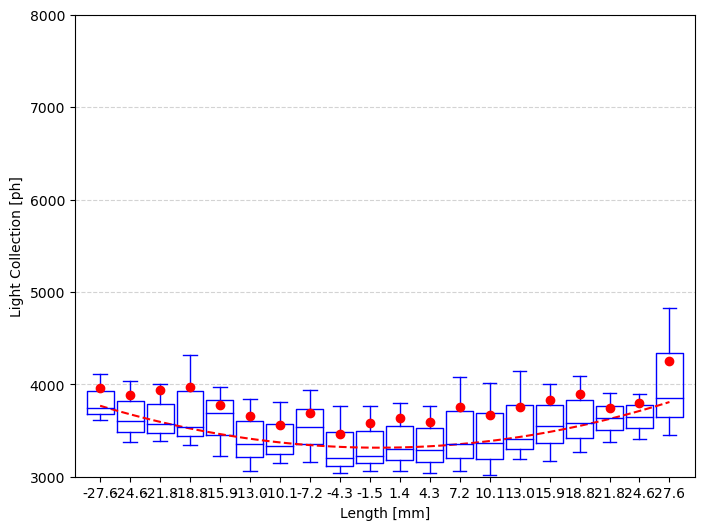

<Figure size 640x480 with 0 Axes>

In [172]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a DataFrame
fnameGC3='EndOfEvent_fPrimaryZ_vs_fLC_box_GC3_quartile_data'
fnameNSGA='EndOfEvent_fPrimaryZ_vs_fLC_box_NSGA_375x3_quartile_data'
fnameFLNSGA='EndOfEvent_fPrimaryZ_vs_fLC_box_FL_375x3_quartile_data'

folder='CSV/'
data = pd.read_csv(folder+fnameGC3+'.csv')

# Calculate the box positions
data['Position'] = (data['Range Max'] + data['Range Min']) / 2*1000
# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))
# Set the y-axis limits
ax.set_ylim(3000, 8000)

# Create boxplots for each row
box_data = [data.loc[i, ['Lower Quartile', 'Median', 'Upper Quartile']].values.tolist()
            for i in range(len(data))]
box_positions = data['Position'].tolist()
box_width = (29 * 2)*0.9 / len(data)  # Set the box width dynamically

boxplot = ax.boxplot(box_data, positions=box_positions, widths=box_width, 
patch_artist=False,  # Set patch_artist to False
                     whiskerprops=dict(color='blue'), capprops=dict(color='blue'),
                     medianprops=dict(color='blue'), flierprops=dict(marker='o', markersize=5,
                                                                     markerfacecolor='black'))

# Set the x-axis limits
ax.set_xlim(-30, 30)


# Add labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Box Plot')

# Add a parabolic fit to the mean values
x_fit = np.linspace(min(box_positions), max(box_positions), 100)
y_fit = np.polyval(np.polyfit(box_positions, data['Median'], 2), x_fit)
ax.plot(x_fit, y_fit, color='red', linestyle='--')

# Add a parabolic fit to the mean values
#x_fit_mean = np.linspace(min(box_positions), max(box_positions), 100)
#y_fit_mean = np.polyval(np.polyfit(box_positions, data['Mean'], 2), x_fit_mean)
#ax.plot(x_fit_mean, y_fit_mean, color='green', linestyle='--')

# Round the x-axis tick labels to the first decimal place
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))


    # Add a grid
ax.grid(True, axis='y', linestyle='--', color='lightgray')


# Calculate the mean of the boxes
mean_values = data['Mean'].to_list()

# Add the 'Mean' data to the plot
ax.plot(box_positions, mean_values, color='red', marker='o', linestyle='', linewidth=1, label='Mean')
    
# Add labels
ax.set_xlabel('Length [mm]')
ax.set_ylabel('Light Collection [ph]')

# Customize the color of all boxes
for box in boxplot['boxes']:
    box.set_color('blue')

# Remove the title
ax.set_title('')

# Show the plot
plt.show()

plt.savefig('CSV/GC3_End.pdf',format='pdf')


In [102]:
plt.savefig(folder +fname+'.pdf')


<Figure size 640x480 with 0 Axes>

In [190]:
box_data

[[3614.0, 3740.0, 4114.0],
 [3371.5, 3604.0, 4035.5],
 [3388.0, 3566.0, 4000.0],
 [3339.5, 3543.5, 4317.5],
 [3219.5, 3693.5, 3968.5],
 [3060.0, 3358.5, 3841.0],
 [3150.0, 3333.0, 3806.0],
 [3161.0, 3537.0, 3937.5],
 [3036.5, 3201.0, 3765.0],
 [3065.0, 3229.5, 3763.5],
 [3065.5, 3303.5, 3799.5],
 [3041.5, 3287.0, 3763.0],
 [3059.0, 3349.5, 4079.0],
 [3023.0, 3367.5, 4016.0],
 [3195.5, 3407.0, 4149.0],
 [3173.0, 3551.0, 4005.0],
 [3265.0, 3578.5, 4089.0],
 [3379.0, 3632.0, 3903.0],
 [3409.5, 3650.0, 3899.0],
 [3451.5, 3850.0, 4827.0]]

[[3051.5, 3614.0, 3740.0, 4114.0, 6041.0], [2981.0, 3371.5, 3604.0, 4035.5, 7287.5], [2957.5, 3388.0, 3566.0, 4000.0, 8462.5], [2858.0, 3339.5, 3543.5, 4317.5, 11280.0], [2884.5, 3219.5, 3693.5, 3968.5, 7540.5], [2774.5, 3060.0, 3358.5, 3841.0, 8707.0], [2749.5, 3150.0, 3333.0, 3806.0, 6608.0], [2601.5, 3161.0, 3537.0, 3937.5, 7963.0], [3.0, 3036.5, 3201.0, 3765.0, 7059.5], [2611.0, 3065.0, 3229.5, 3763.5, 9304.5], [2665.0, 3065.5, 3303.5, 3799.5, 13007.0], [2616.0, 3041.5, 3287.0, 3763.0, 7491.0], [2721.0, 3059.0, 3349.5, 4079.0, 13279.5], [2663.5, 3023.0, 3367.5, 4016.0, 7652.5], [2801.5, 3195.5, 3407.0, 4149.0, 10772.5], [2822.0, 3173.0, 3551.0, 4005.0, 9728.5], [2894.5, 3265.0, 3578.5, 4089.0, 8787.0], [2937.0, 3379.0, 3632.0, 3903.0, 7332.0], [2962.0, 3409.5, 3650.0, 3899.0, 8644.5], [3005.0, 3451.5, 3850.0, 4827.0, 10183.5]]


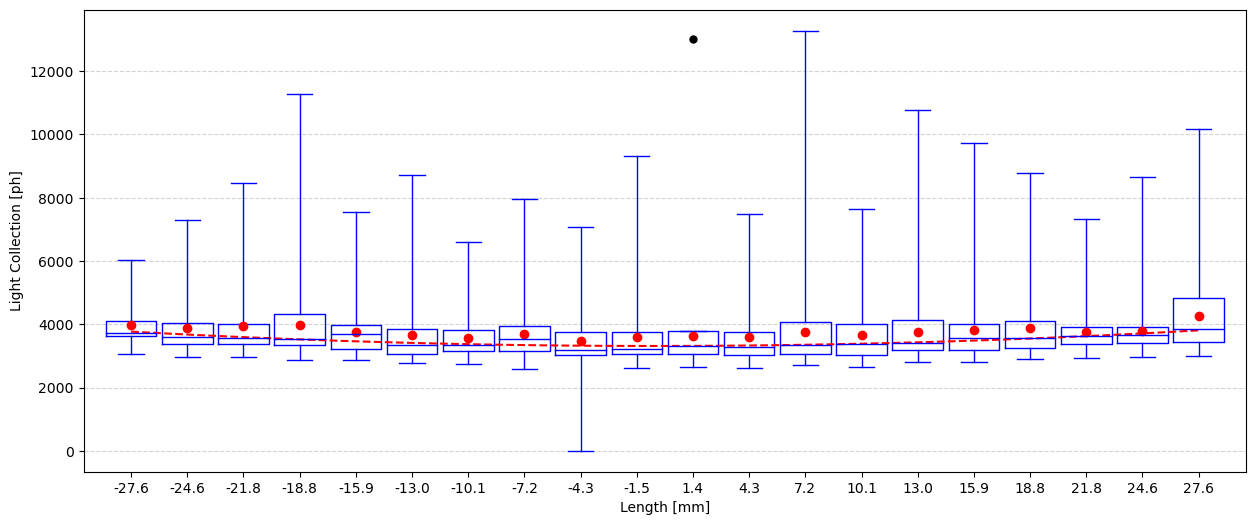

KeyError: 0

In [216]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

fnameGC3 = 'EndOfEvent_fPrimaryZ_vs_fLC_box_GC3__quartile_data'
fnameNSGA = 'EndOfEvent_fPrimaryZ_vs_fLC_box_NSGA_375x3_quartile_data'
fnameFLNSGA = 'EndOfEvent_fPrimaryZ_vs_fLC_box_FL_375x3_quartile_data'

folder = 'CSV/'
data = pd.read_csv(folder + fnameGC3 + '.csv')

# Calculate the box positions
data['Position'] = (data['Range Max'] + data['Range Min']) / 2 * 1000

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Set the y-axis limits
#ax.set_ylim(3000, 5000)

# Create boxplots for each row
box_data = [data.loc[i, ['Min','Lower Quartile', 'Median', 'Upper Quartile','Max']].values.tolist()
#box_data = [[3051.5, 3614.0, 3740.0, 4114.0, 6041.0]
            for i in range(len(data))]
print(box_data)
box_positions = data['Position'].tolist()
box_width = (29 * 2) * 0.9 / len(data)# Increase the range of the whiskers to include outliers
whis_value = 10.0  # Set the box width dynamically

boxplot = ax.boxplot(box_data, positions=box_positions, widths=box_width,
                     patch_artist=False,
                     whiskerprops=dict(color='blue'),
                     capprops=dict(color='blue'),
                     medianprops=dict(color='blue'),
                     flierprops=dict(marker='o', markersize=5, markerfacecolor='black', markeredgecolor='black'),
                    whis=whis_value)


# Set the x-axis limits
ax.set_xlim(-30, 30)

# Add labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Box Plot')

# Add a parabolic fit to the mean values
x_fit = np.linspace(min(box_positions), max(box_positions), 100)
y_fit = np.polyval(np.polyfit(box_positions, data['Median'], 2), x_fit)
ax.plot(x_fit, y_fit, color='red', linestyle='--')

# Add a grid
ax.grid(True, axis='y', linestyle='--', color='lightgray')

# Calculate the mean of the boxes
mean_values = data['Mean'].to_list()

# Add the 'Mean' data to the plot
ax.plot(box_positions, mean_values, color='red', marker='o', linestyle='', linewidth=1, label='Mean')

# Add labels
ax.set_xlabel('Length [mm]')
ax.set_ylabel('Light Collection [ph]')

# Customize the color of all boxes
for box in boxplot['boxes']:
    box.set_color('blue')

# Remove the title
ax.set_title('')
# Round the x-axis tick labels to the first decimal place
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
# Save the figure as a PDF
output_filename = 'CSV/GC3.pdf'
plt.savefig(output_filename, format='pdf')

# Show the plot
plt.show()


In [ ]:
def plot_boxplot(folder,file_path,fig,ax,colorbox,colorfit):

    data = pd.read_csv(folder+fname+'.csv')
    # Calculate the box positions
    data['Position'] = (data['Range Max'] + data['Range Min']) / 2*1000
    data['Position'] 

    # Create boxplots for each row
    box_data = [data.loc[i, ['Lower Quartile', 'Median', 'Upper Quartile']].values.tolist()
                for i in range(len(data))]
    box_positions = data['Position'].tolist()
    box_width = (29 * 2)*0.9 / len(data)  # Set the box width dynamically

    boxplot = ax.boxplot(box_data, positions=box_positions, widths=box_width, 
    patch_artist=False,  # Set patch_artist to False
                         whiskerprops=dict(color='blue'), capprops=dict(color='blue'),
                         medianprops=dict(color='blue'), flierprops=dict(marker='o', markersize=5,
                                                                         markerfacecolor='black'))

    # Set the x-axis limits
    ax.set_xlim(-30, 30)


    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Box Plot')

    # Add a parabolic fit to the mean values
    x_fit = np.linspace(min(box_positions), max(box_positions), 100)
    y_fit = np.polyval(np.polyfit(box_positions, data['Median'], 2), x_fit)
    ax.plot(x_fit, y_fit, color='red', linestyle='--')

    # Add a parabolic fit to the mean values
    #x_fit_mean = np.linspace(min(box_positions), max(box_positions), 100)
    #y_fit_mean = np.polyval(np.polyfit(box_positions, data['Mean'], 2), x_fit_mean)
    #ax.plot(x_fit_mean, y_fit_mean, color='green', linestyle='--')

    # Round the x-axis tick labels to the first decimal place
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))


        # Add a grid
    ax.grid(True, axis='y', linestyle='--', color='lightgray')


    # Calculate the mean of the boxes
    mean_values = data['Mean'].to_list()

    # Add the 'Mean' data to the plot
    ax.plot(box_positions, mean_values, color='red', marker='o', linestyle='', linewidth=1, label='Mean')

    # Add labels
    ax.set_xlabel('Length [mm]')
    ax.set_ylabel('Light Collection [ph]')

    # Customize the color of all boxes
    for box in boxplot['boxes']:
        box.set_color('blue')

    # Remove the title
    ax.set_title('')

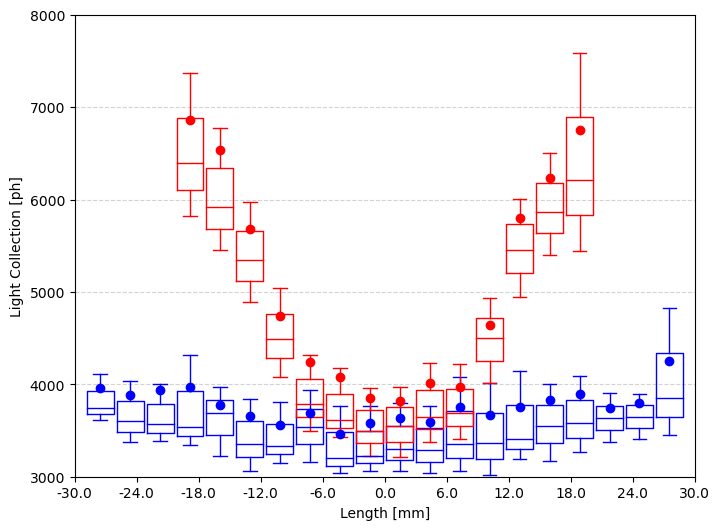

In [185]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

folder = 'CSV/'
fnameGC3 = 'EndOfEvent_fPrimaryZ_vs_fLC_box_GC3_quartile_data'
fnameNSGA = 'EndOfEvent_fPrimaryZ_vs_fLC_box_NSGA_375x3_quartile_data'
fnameFLNSGA = 'EndOfEvent_fPrimaryZ_vs_fLC_box_FL_375x3_quartile_data'

# Read CSV1
fname1 = fnameGC3+'.csv'
data1 = pd.read_csv(folder + fname1)

# Read CSV2
fname2 = fnameNSGA+'.csv'
data2 = pd.read_csv(folder + fname2)

# Calculate the box positions
data1['Position'] = (data1['Range Max'] + data1['Range Min']) / 2 * 1000
data2['Position'] = (data2['Range Max'] + data2['Range Min']) / 2 * 1000

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Set the y-axis limits
ax.set_ylim(3000, 8000)

# Create boxplots for CSV1
box_data1 = [data1.loc[i, ['Lower Quartile', 'Median', 'Upper Quartile']].values.tolist()
             for i in range(len(data1))]
box_positions1 = data1['Position'].tolist()
box_width = (29 * 2) * 0.9 / len(data1)  # Set the box width dynamically

boxplot1 = ax.boxplot(box_data1, positions=box_positions1, widths=box_width,
                      patch_artist=False,
                      whiskerprops=dict(color='blue'), capprops=dict(color='blue'),
                      medianprops=dict(color='blue'), flierprops=dict(marker='o', markersize=5,
                                                                      markerfacecolor='black'))

# Create boxplots for CSV2
box_data2 = [data2.loc[i, ['Lower Quartile', 'Median', 'Upper Quartile']].values.tolist()
             for i in range(len(data2))]
box_positions2 = data2['Position'].tolist()

boxplot2 = ax.boxplot(box_data2, positions=box_positions2, widths=box_width,
                      patch_artist=False,
                      whiskerprops=dict(color='red'), capprops=dict(color='red'),
                      medianprops=dict(color='red'), flierprops=dict(marker='o', markersize=5,
                                                                     markerfacecolor='black'))


# Calculate the mean of the boxes
mean_values1 = data1['Mean'].to_list()
# Add the 'Mean' data to the plot
ax.plot(box_positions1, mean_values1, color='blue', marker='o', linestyle='', linewidth=1, label='Mean')
# Calculate the mean of the boxes
mean_values2 = data2['Mean'].to_list()
# Add the 'Mean' data to the plot
ax.plot(box_positions2, mean_values2, color='red', marker='o', linestyle='', linewidth=1, label='Mean')

# Set the x-axis limits
ax.set_xlim(-30, 30)

# Add labels
ax.set_xlabel('Length [mm]')
ax.set_ylabel('Light Collection [ph]')
    # Customize the color of all boxes
for box in boxplot1['boxes']:
        box.set_color('blue')
for box in boxplot2['boxes']:
        box.set_color('red')

import matplotlib.ticker as mticker

# Set the number of divisions on the x-axis
num_divisions = 10  # Choose the desired number of divisions
ax.xaxis.set_major_locator(mticker.MaxNLocator(num_divisions))

# Display only the first decimal point on the x-axis labels
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

# Add a grid
ax.grid(True, axis='y', linestyle='--', color='lightgray')

# Save the figure as a PDF
output_filename = 'CSV/END_GC3.pdf'
plt.savefig(output_filename, format='pdf')

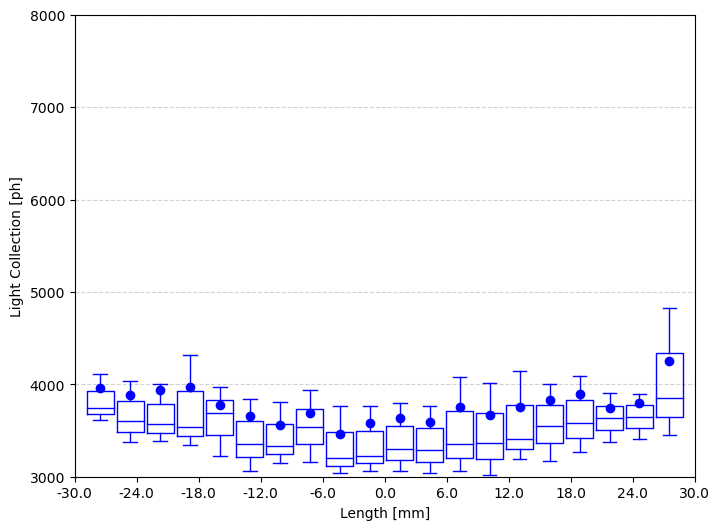

In [186]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

folder = 'CSV/'
fnameGC3 = 'EndOfEvent_fPrimaryZ_vs_fLC_box_GC3_quartile_data'
fnameNSGA = 'EndOfEvent_fPrimaryZ_vs_fLC_box_NSGA_375x3_quartile_data'
fnameFLNSGA = 'EndOfEvent_fPrimaryZ_vs_fLC_box_FL_375x3_quartile_data'

# Read CSV1
fname1 = fnameGC3+'.csv'
data1 = pd.read_csv(folder + fname1)

# Read CSV2
fname2 = fnameNSGA+'.csv'
data2 = pd.read_csv(folder + fname2)

# Calculate the box positions
data1['Position'] = (data1['Range Max'] + data1['Range Min']) / 2 * 1000
data2['Position'] = (data2['Range Max'] + data2['Range Min']) / 2 * 1000

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Set the y-axis limits
ax.set_ylim(3000, 8000)

# Create boxplots for CSV1
box_data1 = [data1.loc[i, ['Lower Quartile', 'Median', 'Upper Quartile']].values.tolist()
             for i in range(len(data1))]
box_positions1 = data1['Position'].tolist()
box_width = (29 * 2) * 0.9 / len(data1)  # Set the box width dynamically

boxplot1 = ax.boxplot(box_data1, positions=box_positions1, widths=box_width,
                      patch_artist=False,
                      whiskerprops=dict(color='blue'), capprops=dict(color='blue'),
                      medianprops=dict(color='blue'), flierprops=dict(marker='o', markersize=5,
                                                                      markerfacecolor='black'))




# Calculate the mean of the boxes
mean_values1 = data1['Mean'].to_list()
# Add the 'Mean' data to the plot
ax.plot(box_positions1, mean_values1, color='blue', marker='o', linestyle='', linewidth=1, label='Mean')


# Set the x-axis limits
ax.set_xlim(-30, 30)

# Add labels
ax.set_xlabel('Length [mm]')
ax.set_ylabel('Light Collection [ph]')
    # Customize the color of all boxes
for box in boxplot1['boxes']:
        box.set_color('blue')


import matplotlib.ticker as mticker

# Set the number of divisions on the x-axis
num_divisions = 10  # Choose the desired number of divisions
ax.xaxis.set_major_locator(mticker.MaxNLocator(num_divisions))

# Display only the first decimal point on the x-axis labels
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

# Add a grid
ax.grid(True, axis='y', linestyle='--', color='lightgray')

# Save the figure as a PDF
output_filename = 'CSV/END_GC3.pdf'
plt.savefig(output_filename, format='pdf')

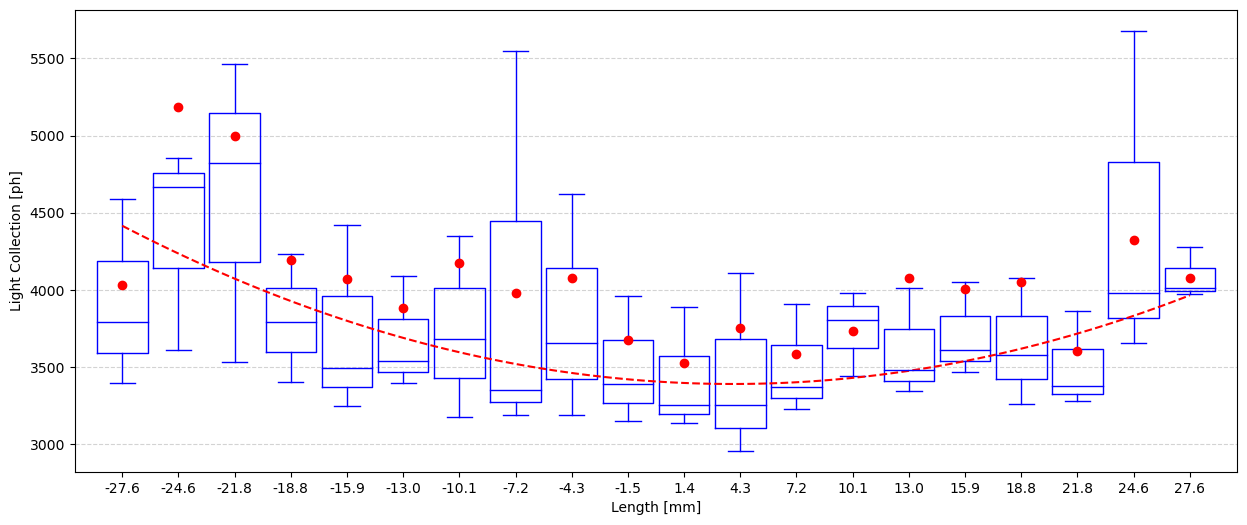

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
# Read the CSV file into a DataFrame
fname='EndOfEvent_fPrimaryZ_vs_fLC_box_FL_375x3_quartile_data'
fname1='EndOfEvent_fPrimaryZ_vs_fLC_box_NSGA_375x3_quartile_data'

folder='CSV/'

fig, ax = plt.subplots(figsize=(15, 6))
plot_boxplot(folder,fname,fig,ax,'blue','blue')
#plot_boxplot(folder,fname,fig,ax,'blue','blue')

plt.show()
#plt.savefig(folder +fname+'.pdf')


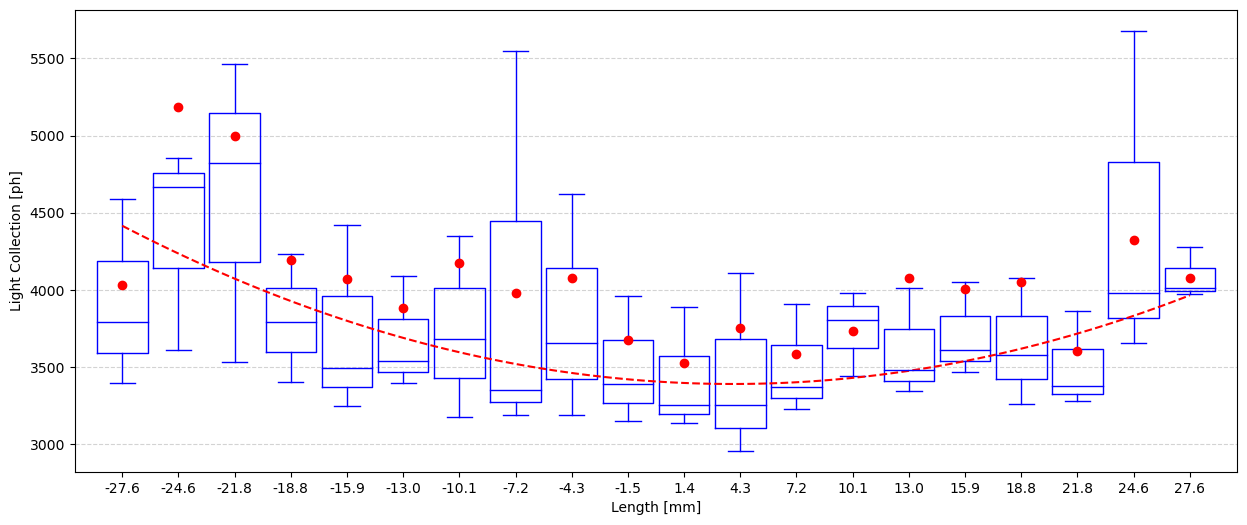

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
# Read the CSV file into a DataFrame
fname1='EndOfEvent_fPrimaryZ_vs_fLC_box_NSGA_375x3_quartile_data'

folder='CSV/'

fig2, ax2 = plt.subplots(figsize=(15, 6))
plot_boxplot(folder,fname1,fig2,ax2,'blue','blue')
#plot_boxplot(folder,fname,fig,ax,'blue','blue')

plt.show()
#plt.savefig(folder +fname+'.pdf')

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_boxplot(folder, file_paths, fig, ax, colorbox, colorfit):
    all_data = []
    all_positions = []

    for file_path in file_paths:
        data = pd.read_csv(folder + file_path + '.csv')
        data['Position'] = (data['Range Max'] + data['Range Min']) / 2 * 1000
        all_positions.extend(data['Position'].tolist())

        box_data = [data.loc[i, ['Lower Quartile', 'Median', 'Upper Quartile']].values.tolist()
                    for i in range(len(data))]
        all_data.extend(box_data)

    box_width = (29 * 2) * 0.9 / len(all_data)  # Set the box width dynamically

    boxplot = ax.boxplot(all_data, positions=all_positions, widths=box_width,
                         patch_artist=False,  # Set patch_artist to False
                         whiskerprops=dict(color='blue'), capprops=dict(color='blue'),
                         medianprops=dict(color='blue'), flierprops=dict(marker='o', markersize=5,
                                                                         markerfacecolor='black'))

    ax.set_xlim(-30, 30)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Box Plot')

    x_fit = np.linspace(min(all_positions), max(all_positions), 100)

    for file_path in file_paths:
        data = pd.read_csv(folder + file_path + '.csv')
        y_fit = np.polyval(np.polyfit(data['Position'], data['Median'], 2), x_fit)
        ax.plot(x_fit, y_fit, color='red', linestyle='--')

    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
    ax.grid(True, axis='y', linestyle='--', color='lightgray')

    for box in boxplot['boxes']:
        box.set_color('blue')

    ax.set_xlabel('Length [mm]')
    ax.set_ylabel('Light Collection [ph]')

    mean_values = []

    for file_path in file_paths:
        data = pd.read_csv(folder + file_path + '.csv')
        mean_values.extend(data['Mean'].tolist())

    ax.plot(all_positions, mean_values, color='red', marker='o', linestyle='', linewidth=1, label='Mean')

    ax.set_title('')


TypeError: plot_boxplot() missing 1 required positional argument: 'colorfit'

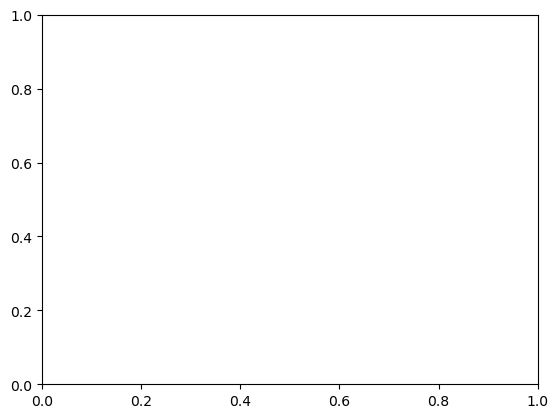

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
# Read the CSV file into a DataFrame
# Read the CSV file into a DataFrame
fnameGC3='EndOfEvent_fPrimaryZ_vs_fLC_box_GC3_quartile_data'
fnameNSGA='EndOfEvent_fPrimaryZ_vs_fLC_box_NSGA_375x3_quartile_data'
fnameFLNSGA='EndOfEvent_fPrimaryZ_vs_fLC_box_NSGA_375x3_quartile_data'
folder='CSV/'

fig, ax = plt.subplots()

plot_boxplot(folder, [fnameGC3,], fig, ax, 'blue', 'blue')
plot_boxplot(folder, [fnameNSGA], fig, ax, 'blue', 'blue')

plt.show()